# Random Forrest and Gradient Boosted Decision Tree Classification on DonorsChoose

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import time
from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('./train_data.csv')
resources_data = pd.read_csv('./resources.csv')
print(project_data.shape)
print(project_data.columns.values)

(109248, 17)
['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [3]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x == 'project_submitted_datetime' else x for x in list(project_data.columns)]

#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

      project_subject_categories            project_subject_subcategories  \
55660             Math & Science  Applied Sciences, Health & Life Science   
76127              Special Needs                            Special Needs   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  
55660                                            53                    1  
76127                                             4                    1

In [4]:
print(resources_data.shape)
print(resources_data.columns.values)

(1541272, 4)
['id' 'description' 'quantity' 'price']


In [5]:
price_data = resources_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')
project_data['price']

0          725.05
1          213.03
2          329.00
3          481.04
4           17.74
5          102.50
6         1418.08
7          495.29
8          299.99
9          479.94
10         393.83
11        1284.12
12          50.96
13           6.81
14         151.15
15          13.99
16         401.93
17         379.98
18         142.18
19         351.54
20         193.53
21          64.89
22          12.47
23         279.98
24         944.92
25         240.51
26         398.88
27         796.19
28         228.83
29         278.88
           ...   
109218      66.49
109219     275.10
109220     379.00
109221     213.94
109222     249.94
109223      98.54
109224     458.99
109225      59.84
109226     207.83
109227     126.66
109228     332.26
109229     492.25
109230     155.44
109231      66.98
109232      69.99
109233     229.98
109234     377.01
109235      74.46
109236     375.96
109237     229.73
109238     181.65
109239     156.99
109240     313.96
109241     292.12
109242    

## 1.2 Preprocessing of project_subject_categories

In [6]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Preprocessing of project_subject_subcategories

In [7]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.4 Text Preprocessing of essays

In [8]:
# merge two column text dataframe: 
project_data["essays"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)
project_data['essays'][2000]

'\\"Creativity is intelligence having fun.\\" --Albert Einstein. Our elementary library at Greenville Elementary is anything but a quiet, hushed space. It\'s a place for collaboration and research. It\'s a place for incorporating technology. It\'s a place for innovation. And it\'s a place for creating.Our school serves 350 third and fourth graders who primarily live in rural and poverty-stricken areas in our community. Being a Title I school, approximately 85% of them receive free or reduced lunch. But they are inquisitive, creative, and eager to learn. They love visiting the library to check out books, hear \\r\\nstories, create digital stories, and use the computer lab for learning and fun. We want to build our library\'s Makerspace with activities revolving around art and literacy to provide more engaging, hands-on activities.We want to begin \\"Makerspace Fridays!\\" Our school recently received a $1000 grant for books for our arts-integrated Makerspace. We have received titles suc

In [9]:
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
# https://gist.github.com/sebleier/554280

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [11]:
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547

from bs4 import BeautifulSoup
from tqdm import tqdm

preprocessed_essays = [];
for sentence in tqdm(project_data['essays'].values):
    sentence = re.sub(r"http\S+", '',sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", '', sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+',' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sentence)

100%|██████████| 109248/109248 [01:32<00:00, 1175.89it/s]


## 1.5 Text Preprocessing of project_title

In [12]:
preprocessed_titles = [];
for sentence in tqdm(project_data['project_title'].values):
    sentence = re.sub(r"http\S+", '',sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", '', sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+',' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sentence)

100%|██████████| 109248/109248 [00:33<00:00, 3293.69it/s]


In [13]:
project_data['clean_essays'] = preprocessed_essays
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [14]:
project_data['clean_titles'] = preprocessed_titles

#https://stackoverflow.com/questions/42224700/attributeerror-float-object-has-no-attribute-split
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna('null')

## 1.6 Preprocessing of Teacher Prefix

In [15]:
project_data['teacher_prefix'].unique()
 

array(['Mrs.', 'Ms.', 'Mr.', 'Teacher', 'null', 'Dr.'], dtype=object)

## 1.7 Computing Sentiment Scores

In [16]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
sentiment_scores = []

for essay in project_data['clean_essays']:
    ss = sid.polarity_scores(essay)
    sentiment_scores.append(ss)
    
neg_sentiment_score = []
neu_sentiment_score = []
pos_sentiment_score = []
comp_sentiment_score = []

for item in sentiment_scores:
    neg_sentiment_score.append(item['neg'])
    neu_sentiment_score.append(item['neu'])
    pos_sentiment_score.append(item['pos'])
    comp_sentiment_score.append(item['compound'])

In [17]:
project_data['essays_neg_score'] = neg_sentiment_score
project_data['essays_neu_score'] = neu_sentiment_score
project_data['essays_pos_score'] = pos_sentiment_score
project_data['essays_comp_score'] = comp_sentiment_score

## 1.8 Computing number of words in essays and titles

In [18]:
essay_word_count = project_data['clean_essays'].str.split().apply(len)
title_word_count = project_data['clean_titles'].str.split().apply(len)
project_data['clean_essays_word_count'] = essay_word_count
project_data['clean_titles_word_count'] = title_word_count

## 2. Splitting the data

In [19]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
x = project_data

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33,stratify=y)
x_train, x_cv, y_train, y_cv = train_test_split(x_train,y_train,test_size=0.33,stratify=y_train)

print(x_train.shape, y_train.shape)
print(x_cv.shape, y_cv.shape)
print(x_test.shape, y_test.shape)

(49041, 23) (49041,)
(24155, 23) (24155,)
(36052, 23) (36052,)


## 3. Preparing data for model

In [21]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'clean_categories', 'clean_subcategories', 'essays', 'clean_essays',
       'clean_titles', 'essays_neg_score', 'essays_neu_score',
       'essays_pos_score', 'essays_comp_score', 'clean_essays_word_count',
       'clean_titles_word_count'],
      dtype='object')

We are going to consider only the following features :-

1. Categorical Data
   - teacher_prefix
   - school_state
   - project_grade_category
   - clean_categories
   - cleaned_subcategories
   
   
2. Text Data
   - project_title
   - Essays
   - project_resources
   
   
3. Numerical Data
   - price
   - quantity
   - teacher_number_of_previously_posted_projects
   - resource_summary_contains_number
   - clean_essays_word_count
   - clean_titles_word_count
   - essays_neg_score
   - essays_neu_score
   - essays_pos_score
   - essays_comp_score

### 3.1 Vectorizing Categorical Data

#### 1. Clean Categories

In [22]:
x_train_pos = x_train.loc[y_train == 1]

clean_category_pos = {}

for a in x_train_pos['clean_categories'] :
    for b in a.split():
        if b not in clean_category_pos :
            clean_category_pos[b] = 1
        else :
            clean_category_pos[b] += 1
clean_category_pos

{'Health_Sports': 5369,
 'Literacy_Language': 20255,
 'Math_Science': 15662,
 'AppliedLearning': 4529,
 'SpecialNeeds': 5135,
 'Music_Arts': 3901,
 'History_Civics': 2252,
 'Warmth': 589,
 'Care_Hunger': 589}

In [23]:
x_train_neg = x_train.loc[y_train == 0]

clean_category_neg = {}

for a in x_train_neg['clean_categories'] :
    for b in a.split():
        if b not in clean_category_neg :
            clean_category_neg[b] = 1
        else :
            clean_category_neg[b] += 1
clean_category_neg

{'History_Civics': 366,
 'Health_Sports': 1005,
 'Math_Science': 2922,
 'Literacy_Language': 3148,
 'AppliedLearning': 919,
 'Music_Arts': 722,
 'SpecialNeeds': 1031,
 'Warmth': 60,
 'Care_Hunger': 60}

In [24]:
clean_category_total = {}

for a in x_train['clean_categories'] :
    for b in a.split():
        if b not in clean_category_total :
            clean_category_total[b] = 1
        else :
            clean_category_total[b] += 1
clean_category_total

{'Health_Sports': 6374,
 'Literacy_Language': 23403,
 'Math_Science': 18584,
 'AppliedLearning': 5448,
 'SpecialNeeds': 6166,
 'History_Civics': 2618,
 'Music_Arts': 4623,
 'Warmth': 649,
 'Care_Hunger': 649}

In [25]:
pos_prob_category = {}

for st in clean_category_total.keys():
    pos_prob_category[st] = (clean_category_pos[st])/float(clean_category_total[st])
    
neg_prob_category = {}

for stt in clean_category_total.keys():
    neg_prob_category[stt] = (clean_category_neg[stt])/float(clean_category_total[stt])
neg_prob_category

{'Health_Sports': 0.1576717916535927,
 'Literacy_Language': 0.13451266931589967,
 'Math_Science': 0.15723202755058113,
 'AppliedLearning': 0.16868575624082233,
 'SpecialNeeds': 0.16720726565034058,
 'History_Civics': 0.13980137509549273,
 'Music_Arts': 0.15617564352152283,
 'Warmth': 0.09244992295839753,
 'Care_Hunger': 0.09244992295839753}

In [26]:
cat_0_train = []
cat_1_train = []

for a in x_train["clean_categories"] :
    b = a.split()
    if len(b) == 1 :
        cat_0_train.append(neg_prob_category[a])
        cat_1_train.append(pos_prob_category[a])
    else :
        c = neg_prob_category[b[0]]
        d = neg_prob_category[b[1]]
        e = pos_prob_category[b[0]]
        f = pos_prob_category[b[1]]
        
        cat_0_train.append(c*d)
        cat_1_train.append(e*f)

In [27]:
x_train["cat_0"] = cat_0_train
x_train["cat_1"] = cat_1_train

In [28]:
cat_0_cv = []
cat_1_cv = []

for a in x_cv["clean_categories"] :
    b = a.split()
    if len(b) == 1 :
        cat_0_cv.append(neg_prob_category[a])
        cat_1_cv.append(pos_prob_category[a])
    else :
        c = neg_prob_category[b[0]]
        d = neg_prob_category[b[1]]
        e = pos_prob_category[b[0]]
        f = pos_prob_category[b[1]]
        
        cat_0_cv.append(c*d)
        cat_1_cv.append(e*f)

In [29]:
x_cv["cat_0"] = cat_0_cv
x_cv["cat_1"] = cat_1_cv

In [30]:
cat_0_test = []
cat_1_test = []

for a in x_test["clean_categories"] :
    b = a.split()
    if len(b) == 1 :
        cat_0_test.append(neg_prob_category[a])
        cat_1_test.append(pos_prob_category[a])
    else :
        c = neg_prob_category[b[0]]
        d = neg_prob_category[b[1]]
        e = pos_prob_category[b[0]]
        f = pos_prob_category[b[1]]
        
        cat_0_test.append(c*d)
        cat_1_test.append(e*f)

In [31]:
x_test["cat_0"] = cat_0_test
x_test["cat_1"] = cat_1_test

In [32]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(x_train["cat_0"].values.reshape(-1,1))

cat_0_train = normalizer.transform(x_train["cat_0"].values.reshape(-1,1))
cat_0_cv = normalizer.transform(x_cv["cat_0"].values.reshape(-1,1))
cat_0_test = normalizer.transform(x_test["cat_0"].values.reshape(-1,1))

print("After vectorizations")
print(cat_0_train.shape, y_train.shape)
print(cat_0_cv.shape, y_cv.shape)
print(cat_0_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [33]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(x_train["cat_1"].values.reshape(-1,1))

cat_1_train = normalizer.transform(x_train["cat_1"].values.reshape(-1,1))
cat_1_cv = normalizer.transform(x_cv["cat_1"].values.reshape(-1,1))
cat_1_test = normalizer.transform(x_test["cat_1"].values.reshape(-1,1))

print("After vectorizations")
print(cat_1_train.shape, y_train.shape)
print(cat_1_cv.shape, y_cv.shape)
print(cat_1_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


#### 2. Clean Subcategories

In [34]:
x_train_pos = x_train.loc[y_train == 1]

clean_subcategory_pos = {}

for a in x_train_pos['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcategory_pos :
            clean_subcategory_pos[b] = 1
        else :
            clean_subcategory_pos[b] += 1
clean_subcategory_pos

{'TeamSports': 794,
 'Gym_Fitness': 1664,
 'Health_Wellness': 3910,
 'Literacy': 13140,
 'Mathematics': 10687,
 'CharacterEducation': 756,
 'Literature_Writing': 8610,
 'ParentInvolvement': 255,
 'EnvironmentalScience': 2059,
 'Health_LifeScience': 1571,
 'SpecialNeeds': 5135,
 'Music': 1242,
 'VisualArts': 2330,
 'History_Geography': 1233,
 'SocialSciences': 717,
 'AppliedSciences': 4041,
 'ESL': 1644,
 'College_CareerPrep': 964,
 'Extracurricular': 308,
 'Warmth': 589,
 'Care_Hunger': 589,
 'CommunityService': 164,
 'EarlyDevelopment': 1565,
 'Other': 884,
 'PerformingArts': 738,
 'ForeignLanguages': 318,
 'NutritionEducation': 482,
 'Civics_Government': 304,
 'Economics': 106,
 'FinancialLiteracy': 203}

In [35]:
x_train_neg = x_train.loc[y_train == 0]

clean_subcategory_neg = {}

for a in x_train_neg['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcategory_neg :
            clean_subcategory_neg[b] = 1
        else :
            clean_subcategory_neg[b] += 1
clean_subcategory_neg

{'SocialSciences': 115,
 'Health_Wellness': 666,
 'AppliedSciences': 828,
 'Literature_Writing': 1403,
 'Other': 195,
 'EarlyDevelopment': 322,
 'Music': 165,
 'Literacy': 1940,
 'SpecialNeeds': 1031,
 'History_Geography': 193,
 'Gym_Fitness': 318,
 'Mathematics': 1893,
 'ESL': 282,
 'Health_LifeScience': 334,
 'Warmth': 60,
 'Care_Hunger': 60,
 'EnvironmentalScience': 440,
 'College_CareerPrep': 192,
 'VisualArts': 503,
 'TeamSports': 207,
 'NutritionEducation': 105,
 'ForeignLanguages': 82,
 'CommunityService': 43,
 'CharacterEducation': 170,
 'ParentInvolvement': 39,
 'PerformingArts': 123,
 'Extracurricular': 49,
 'FinancialLiteracy': 44,
 'Civics_Government': 53,
 'Economics': 19}

In [36]:
clean_subcategory_total = {}

for a in x_train['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcategory_total :
            clean_subcategory_total[b] = 1
        else :
            clean_subcategory_total[b] += 1
clean_subcategory_total

{'TeamSports': 1001,
 'Gym_Fitness': 1982,
 'Health_Wellness': 4576,
 'Literacy': 15080,
 'Mathematics': 12580,
 'CharacterEducation': 926,
 'Literature_Writing': 10013,
 'ParentInvolvement': 294,
 'EnvironmentalScience': 2499,
 'Health_LifeScience': 1905,
 'SpecialNeeds': 6166,
 'SocialSciences': 832,
 'Music': 1407,
 'VisualArts': 2833,
 'History_Geography': 1426,
 'AppliedSciences': 4869,
 'Other': 1079,
 'EarlyDevelopment': 1887,
 'ESL': 1926,
 'College_CareerPrep': 1156,
 'Extracurricular': 357,
 'Warmth': 649,
 'Care_Hunger': 649,
 'CommunityService': 207,
 'PerformingArts': 861,
 'ForeignLanguages': 400,
 'NutritionEducation': 587,
 'Civics_Government': 357,
 'Economics': 125,
 'FinancialLiteracy': 247}

In [37]:
pos_prob_subcategory = {}

for st in clean_subcategory_total.keys():
    pos_prob_subcategory[st] = (clean_subcategory_pos[st])/float(clean_subcategory_total[st])
    
neg_prob_subcategory = {}

for stt in clean_subcategory_total.keys():
    neg_prob_subcategory[stt] = (clean_subcategory_neg[stt])/float(clean_subcategory_total[stt])

In [38]:
subcat_0_train = []
subcat_1_train = []

for a in x_train["clean_subcategories"] :
    b = a.split()
    if len(b) == 1 :
        subcat_0_train.append(neg_prob_subcategory[a])
        subcat_1_train.append(pos_prob_subcategory[a])
    else :
        c = neg_prob_subcategory[b[0]]
        d = neg_prob_subcategory[b[1]]
        e = pos_prob_subcategory[b[0]]
        f = pos_prob_subcategory[b[1]]
        
        subcat_0_train.append(c*d)
        subcat_1_train.append(e*f)

In [39]:
x_train["subcat_0"] = subcat_0_train
x_train["subcat_1"] = subcat_1_train

In [40]:
subcat_0_cv = []
subcat_1_cv = []

for a in x_cv["clean_subcategories"] :
    b = a.split()
    if len(b) == 1 :
        subcat_0_cv.append(neg_prob_subcategory[a])
        subcat_1_cv.append(pos_prob_subcategory[a])
    else :
        c = neg_prob_subcategory[b[0]]
        d = neg_prob_subcategory[b[1]]
        e = pos_prob_subcategory[b[0]]
        f = pos_prob_subcategory[b[1]]
        
        subcat_0_cv.append(c*d)
        subcat_1_cv.append(e*f)

In [41]:
x_cv["subcat_0"] = subcat_0_cv
x_cv["subcat_1"] = subcat_1_cv

In [42]:
subcat_0_test = []
subcat_1_test = []

for a in x_test["clean_subcategories"] :
    b = a.split()
    if len(b) == 1 :
        subcat_0_test.append(neg_prob_subcategory[a])
        subcat_1_test.append(pos_prob_subcategory[a])
    else :
        c = neg_prob_subcategory[b[0]]
        d = neg_prob_subcategory[b[1]]
        e = pos_prob_subcategory[b[0]]
        f = pos_prob_subcategory[b[1]]
        
        subcat_0_test.append(c*d)
        subcat_1_test.append(e*f)

In [43]:
x_test["subcat_0"] = subcat_0_test
x_test["subcat_1"] = subcat_1_test

In [44]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(x_train["cat_0"].values.reshape(-1,1))

subcat_0_train = normalizer.transform(x_train["subcat_0"].values.reshape(-1,1))
subcat_0_cv = normalizer.transform(x_cv["subcat_0"].values.reshape(-1,1))
subcat_0_test = normalizer.transform(x_test["subcat_0"].values.reshape(-1,1))

print("After vectorizations")
print(subcat_0_train.shape, y_train.shape)
print(subcat_0_cv.shape, y_cv.shape)
print(subcat_0_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [45]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(x_train["cat_1"].values.reshape(-1,1))

subcat_1_train = normalizer.transform(x_train["subcat_1"].values.reshape(-1,1))
subcat_1_cv = normalizer.transform(x_cv["subcat_1"].values.reshape(-1,1))
subcat_1_test = normalizer.transform(x_test["subcat_1"].values.reshape(-1,1))

print("After vectorizations")
print(subcat_1_train.shape, y_train.shape)
print(subcat_1_cv.shape, y_cv.shape)
print(subcat_1_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


#### 3. Project Grade Category

In [46]:
project_grade_pos = {}

for a in x_train_pos['project_grade_category'] :
    if a not in project_grade_pos :
        project_grade_pos[a] = 1
    else :
        project_grade_pos[a] += 1
project_grade_pos

{'Grades 6-8': 6411,
 'Grades 9-12': 4178,
 'Grades PreK-2': 16700,
 'Grades 3-5': 14326}

In [47]:
project_grade_neg = {}

for a in x_train_neg['project_grade_category'] :
    if a not in project_grade_neg :
        project_grade_neg[a] = 1
    else :
        project_grade_neg[a] += 1
project_grade_neg

{'Grades 3-5': 2501,
 'Grades PreK-2': 2954,
 'Grades 9-12': 810,
 'Grades 6-8': 1161}

In [48]:
project_grade_total = {}

for a in x_train['project_grade_category'] :
    if a not in project_grade_total :
        project_grade_total[a] = 1
    else :
        project_grade_total[a] += 1            

project_grade_total

{'Grades 6-8': 7572,
 'Grades 9-12': 4988,
 'Grades PreK-2': 19654,
 'Grades 3-5': 16827}

In [49]:
pos_prob_grade_cat = {}

for sq in project_grade_total.keys():
    pos_prob_grade_cat[sq] = (project_grade_pos[sq])/float(project_grade_total[sq])
    
neg_prob_grade_cat = {}

for sq in project_grade_total.keys():
    neg_prob_grade_cat[sq] = (project_grade_neg[sq])/float(project_grade_total[sq])

In [50]:
proj_grade_0_train = []
proj_grade_1_train = []

for a in x_train["project_grade_category"] :
    proj_grade_0_train.append(neg_prob_grade_cat[a])
    proj_grade_1_train.append(pos_prob_grade_cat[a])
    
x_train["proj_grade_0"] = proj_grade_0_train
x_train["proj_grade_1"] = proj_grade_1_train

In [51]:
proj_grade_0_cv = []
proj_grade_1_cv = []

for a in x_cv["project_grade_category"] :
    proj_grade_0_cv.append(neg_prob_grade_cat[a])
    proj_grade_1_cv.append(pos_prob_grade_cat[a])
    
x_cv["proj_grade_0"] = proj_grade_0_cv
x_cv["proj_grade_1"] = proj_grade_1_cv

In [52]:
proj_grade_0_test = []
proj_grade_1_test = []

for a in x_test["project_grade_category"] :
    proj_grade_0_test.append(neg_prob_grade_cat[a])
    proj_grade_1_test.append(pos_prob_grade_cat[a])
    
x_test["proj_grade_0"] = proj_grade_0_test
x_test["proj_grade_1"] = proj_grade_1_test

In [53]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(x_train["proj_grade_0"].values.reshape(-1,1))

proj_grade_0_train = normalizer.transform(x_train["proj_grade_0"].values.reshape(-1,1))
proj_grade_0_cv = normalizer.transform(x_cv["proj_grade_0"].values.reshape(-1,1))
proj_grade_0_test = normalizer.transform(x_test["proj_grade_0"].values.reshape(-1,1))

print("After vectorizations")
print(proj_grade_0_train.shape, y_train.shape)
print(proj_grade_0_cv.shape, y_cv.shape)
print(proj_grade_0_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [54]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(x_train["proj_grade_1"].values.reshape(-1,1))

proj_grade_1_train = normalizer.transform(x_train["proj_grade_1"].values.reshape(-1,1))
proj_grade_1_cv = normalizer.transform(x_cv["proj_grade_1"].values.reshape(-1,1))
proj_grade_1_test = normalizer.transform(x_test["proj_grade_1"].values.reshape(-1,1))

print("After vectorizations")
print(proj_grade_1_train.shape, y_train.shape)
print(proj_grade_1_cv.shape, y_cv.shape)
print(proj_grade_1_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


#### 4. Teacher Prefix

In [55]:
teacher_prefix_pos = {}

for a in x_train_pos['teacher_prefix'] :
    if a not in teacher_prefix_pos :
        teacher_prefix_pos[a] = 1
    else :
        teacher_prefix_pos[a] += 1
teacher_prefix_pos

{'Mr.': 3994, 'Mrs.': 22080, 'Ms.': 14710, 'Teacher': 825, 'Dr.': 6}

In [56]:
teacher_prefix_neg = {}

for a in x_train_neg['teacher_prefix'] :
    if a not in teacher_prefix_neg :
        teacher_prefix_neg[a] = 1
    else :
        teacher_prefix_neg[a] += 1
        
teacher_prefix_neg

{'Ms.': 2737, 'Mrs.': 3713, 'Mr.': 759, 'Teacher': 216, 'Dr.': 1}

In [57]:
teacher_prefix_total = {}

for a in x_train['teacher_prefix'] :
    if a not in teacher_prefix_total :
        teacher_prefix_total[a] = 1
    else :
        teacher_prefix_total[a] += 1
teacher_prefix_total

{'Mr.': 4753, 'Mrs.': 25793, 'Ms.': 17447, 'Teacher': 1041, 'Dr.': 7}

In [58]:
# del teacher_prefix_total['null']

pos_prob_teacher_prefix = {}
neg_prob_teacher_prefix = {}

for sw in teacher_prefix_total.keys():
    pos_prob_teacher_prefix[sw] = (teacher_prefix_pos[sw])/float(teacher_prefix_total[sw])

for sw in teacher_prefix_total.keys():
    neg_prob_teacher_prefix[sw] = (0.05 if sw == 'null'else teacher_prefix_neg[sw])/float(0.05 if sw == 'null' else teacher_prefix_total[sw])
                                                                 
                                                                                                                                

In [59]:
teacher_prefix_0_train = []
teacher_prefix_1_train = []

for a in x_train["teacher_prefix"] :
    teacher_prefix_0_train.append(0.05 if a == 'null' else neg_prob_teacher_prefix[a])
    teacher_prefix_1_train.append(0.05 if a == 'null' else pos_prob_teacher_prefix[a])
    
x_train["teacher_prefix_0"] = teacher_prefix_0_train
x_train["teacher_prefix_1"] = teacher_prefix_1_train

In [60]:
teacher_prefix_0_cv = []
teacher_prefix_1_cv = []

for a in x_cv["teacher_prefix"] :
#     print(a)
    teacher_prefix_0_cv.append(0.05 if a == 'null' else neg_prob_teacher_prefix[a])
    teacher_prefix_1_cv.append(0.05 if a == 'null' else pos_prob_teacher_prefix[a])
    
x_cv["teacher_prefix_0"] = teacher_prefix_0_cv
x_cv["teacher_prefix_1"] = teacher_prefix_1_cv

In [61]:
teacher_prefix_0_test = []
teacher_prefix_1_test = []

for a in x_test["teacher_prefix"] :
    teacher_prefix_0_test.append(0.05 if a == 'null' else neg_prob_teacher_prefix[a])
    teacher_prefix_1_test.append(0.05 if a == 'null' else pos_prob_teacher_prefix[a])
    
x_test["teacher_prefix_0"] = teacher_prefix_0_test
x_test["teacher_prefix_1"] = teacher_prefix_1_test

In [62]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(x_train["teacher_prefix_0"].values.reshape(-1,1))

teacher_prefix_0_train = normalizer.transform(x_train["teacher_prefix_0"].values.reshape(-1,1))
teacher_prefix_0_cv = normalizer.transform(x_cv["teacher_prefix_0"].values.reshape(-1,1))
teacher_prefix_0_test = normalizer.transform(x_test["teacher_prefix_0"].values.reshape(-1,1))

print("After vectorizations")
print(teacher_prefix_0_train.shape, y_train.shape)
print(teacher_prefix_0_cv.shape, y_cv.shape)
print(teacher_prefix_0_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [63]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(x_train["teacher_prefix_1"].values.reshape(-1,1))

teacher_prefix_1_train = normalizer.transform(x_train["teacher_prefix_1"].values.reshape(-1,1))
teacher_prefix_1_cv = normalizer.transform(x_cv["teacher_prefix_1"].values.reshape(-1,1))
teacher_prefix_1_test = normalizer.transform(x_test["teacher_prefix_1"].values.reshape(-1,1))

print("After vectorizations")
print(teacher_prefix_1_train.shape, y_train.shape)
print(teacher_prefix_1_cv.shape, y_cv.shape)
print(teacher_prefix_1_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


#### 5. School State

In [64]:
school_state_pos = {}

for a in x_train_pos['school_state'] :
    if a not in school_state_pos :
        school_state_pos[a] = 1
    else :
        school_state_pos[a] += 1
school_state_pos

{'IL': 1647,
 'CA': 5987,
 'CT': 622,
 'VA': 805,
 'LA': 926,
 'FL': 2331,
 'OR': 478,
 'IA': 239,
 'OH': 961,
 'TX': 2706,
 'MA': 924,
 'DE': 134,
 'OK': 827,
 'PA': 1152,
 'NJ': 863,
 'CO': 414,
 'MO': 1005,
 'NY': 2834,
 'SC': 1500,
 'NC': 1994,
 'KY': 516,
 'RI': 116,
 'KS': 232,
 'NV': 523,
 'MI': 1219,
 'NH': 134,
 'UT': 622,
 'WA': 888,
 'AZ': 765,
 'TN': 654,
 'AR': 389,
 'GA': 1492,
 'MN': 472,
 'ME': 187,
 'ND': 54,
 'AK': 126,
 'ID': 262,
 'AL': 674,
 'NE': 123,
 'NM': 217,
 'MS': 496,
 'WY': 33,
 'DC': 182,
 'WV': 193,
 'IN': 1001,
 'MD': 561,
 'WI': 714,
 'HI': 201,
 'MT': 86,
 'SD': 102,
 'VT': 32}

In [65]:
school_state_neg = {}

for a in x_train_neg['school_state'] :
    if a not in school_state_neg :
        school_state_neg[a] = 1
    else :
        school_state_neg[a] += 1
school_state_neg

{'IL': 280,
 'SC': 274,
 'GA': 259,
 'NJ': 181,
 'NY': 463,
 'LA': 175,
 'TX': 630,
 'FL': 460,
 'CO': 74,
 'CT': 117,
 'WA': 113,
 'CA': 987,
 'OR': 77,
 'OK': 170,
 'MS': 105,
 'NV': 82,
 'VA': 140,
 'PA': 190,
 'MA': 148,
 'AZ': 122,
 'NC': 319,
 'ID': 39,
 'KY': 81,
 'MI': 222,
 'OH': 132,
 'KS': 54,
 'MD': 102,
 'AR': 81,
 'WI': 109,
 'IN': 200,
 'MN': 90,
 'AL': 129,
 'IA': 45,
 'MO': 167,
 'TN': 114,
 'ME': 32,
 'WV': 35,
 'DC': 41,
 'VT': 9,
 'UT': 135,
 'NH': 18,
 'AK': 32,
 'NE': 25,
 'RI': 15,
 'HI': 43,
 'NM': 39,
 'MT': 17,
 'SD': 21,
 'DE': 15,
 'ND': 9,
 'WY': 9}

In [66]:
school_state_total = {}

for a in x_train['school_state'] :
    if a not in school_state_total :
        school_state_total[a] = 1
    else :
        school_state_total[a] += 1
school_state_total

{'IL': 1927,
 'CA': 6974,
 'CT': 739,
 'VA': 945,
 'LA': 1101,
 'FL': 2791,
 'OR': 555,
 'IA': 284,
 'SC': 1774,
 'OH': 1093,
 'GA': 1751,
 'TX': 3336,
 'NJ': 1044,
 'MA': 1072,
 'DE': 149,
 'OK': 997,
 'NY': 3297,
 'PA': 1342,
 'CO': 488,
 'MO': 1172,
 'NC': 2313,
 'KY': 597,
 'RI': 131,
 'KS': 286,
 'NV': 605,
 'MI': 1441,
 'NH': 152,
 'UT': 757,
 'WA': 1001,
 'AZ': 887,
 'TN': 768,
 'AR': 470,
 'MN': 562,
 'MS': 601,
 'ME': 219,
 'ND': 63,
 'AK': 158,
 'ID': 301,
 'AL': 803,
 'NE': 148,
 'NM': 256,
 'WY': 42,
 'DC': 223,
 'WV': 228,
 'IN': 1201,
 'MD': 663,
 'WI': 823,
 'HI': 244,
 'MT': 103,
 'SD': 123,
 'VT': 41}

In [67]:
pos_prob_state = {}

for state in school_state_total.keys():
    pos_prob_state[state] = (school_state_pos[state])/float(school_state_total[state])
    
neg_prob_state = {}

for state in school_state_total.keys():
    neg_prob_state[state] = (school_state_neg[state])/float(school_state_total[state])

In [68]:
state_0_train = []
state_1_train = []

for a in x_train["school_state"] :
    state_0_train.append(neg_prob_state[a])
    state_1_train.append(pos_prob_state[a])
    
x_train["state_0"] =state_0_train
x_train["state_1"] =state_1_train

In [69]:
state_0_cv = []
state_1_cv = []

for a in x_cv["school_state"] :
    state_0_cv.append(neg_prob_state[a])
    state_1_cv.append(pos_prob_state[a])
    
x_cv["state_0"] =state_0_cv
x_cv["state_1"] =state_1_cv

In [70]:
state_0_test = []
state_1_test = []

for a in x_test["school_state"] :
    state_0_test.append(neg_prob_state[a])
    state_1_test.append(pos_prob_state[a])
    
x_test["state_0"] =state_0_test
x_test["state_1"] =state_1_test

In [71]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(x_train["state_0"].values.reshape(-1,1))

state_0_train = normalizer.transform(x_train["state_0"].values.reshape(-1,1))
state_0_cv = normalizer.transform(x_cv["state_0"].values.reshape(-1,1))
state_0_test = normalizer.transform(x_test["state_0"].values.reshape(-1,1))

print("After vectorizations")
print(state_0_train.shape, y_train.shape)
print(state_0_cv.shape, y_cv.shape)
print(state_0_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [72]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer.fit(x_train["state_1"].values.reshape(-1,1))

state_1_train = normalizer.transform(x_train["state_1"].values.reshape(-1,1))
state_1_cv = normalizer.transform(x_cv["state_1"].values.reshape(-1,1))
state_1_test = normalizer.transform(x_test["state_1"].values.reshape(-1,1))

print("After vectorizations")
print(state_1_train.shape, y_train.shape)
print(state_1_cv.shape, y_cv.shape)
print(state_1_test.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 3.2 Vectorizing Text Data

#### 1. Essays

##### Bag of Words (BoW)

In [73]:
bow_vectorizer_essays = CountVectorizer(min_df = 10, ngram_range=(1,2), max_features=5000)

x_train_essays_bow = bow_vectorizer_essays.fit_transform(x_train['clean_essays'])
x_cv_essays_bow = bow_vectorizer_essays.transform(x_cv['clean_essays'])
x_test_essays_bow = bow_vectorizer_essays.transform(x_test['clean_essays'])
print(x_train_essays_bow.shape)
print(x_cv_essays_bow.shape)
print(x_test_essays_bow.shape)

(49041, 5000)
(24155, 5000)
(36052, 5000)


##### TFIDF Vectorizer

In [74]:
tfidf_vectorizer_essays = TfidfVectorizer(min_df = 10, ngram_range=(1,2), max_features=5000)

x_train_essays_tfidf = tfidf_vectorizer_essays.fit_transform(x_train['clean_essays'])
x_cv_essays_tfidf = tfidf_vectorizer_essays.transform(x_cv['clean_essays'])
x_test_essays_tfidf = tfidf_vectorizer_essays.transform(x_test['clean_essays'])
print(x_train_essays_tfidf.shape)
print(x_cv_essays_tfidf.shape)
print(x_test_essays_tfidf.shape)

(49041, 5000)
(24155, 5000)
(36052, 5000)


##### Average Word2Vector (AVG W2V)

In [75]:
# Taking referrence from Amazon Fine Food Reviews

essays_sentences = []
for sentence in x_train['clean_essays']:
    essays_sentences.append(sentence)

In [76]:
essays_w2v_model = Word2Vec(essays_sentences, min_count=5, size=300, workers=5) 
essays_w2v_words = essays_w2v_model.wv.vocab
essays_w2v_words

{'s': <gensim.models.keyedvectors.Vocab at 0x1a40929f28>,
 't': <gensim.models.keyedvectors.Vocab at 0x1a1b267550>,
 'u': <gensim.models.keyedvectors.Vocab at 0x1a223a2c18>,
 'd': <gensim.models.keyedvectors.Vocab at 0x1a20145390>,
 'e': <gensim.models.keyedvectors.Vocab at 0x1a22363780>,
 'n': <gensim.models.keyedvectors.Vocab at 0x1a409be160>,
 ' ': <gensim.models.keyedvectors.Vocab at 0x1a409be278>,
 'c': <gensim.models.keyedvectors.Vocab at 0x1a409beef0>,
 'o': <gensim.models.keyedvectors.Vocab at 0x1a4ea0d550>,
 'm': <gensim.models.keyedvectors.Vocab at 0x1a4ea0dc50>,
 'l': <gensim.models.keyedvectors.Vocab at 0x1a4ea0df28>,
 'w': <gensim.models.keyedvectors.Vocab at 0x1a4ea0d898>,
 'i': <gensim.models.keyedvectors.Vocab at 0x1a4ea0de10>,
 'h': <gensim.models.keyedvectors.Vocab at 0x1a4ea0d390>,
 'g': <gensim.models.keyedvectors.Vocab at 0x1a4ea0dd30>,
 'p': <gensim.models.keyedvectors.Vocab at 0x1a4ea0d5f8>,
 'v': <gensim.models.keyedvectors.Vocab at 0x1a4ea0d6d8>,
 'r': <gensim.

In [77]:
x_train_essays_w2v_vectors = []

for sent in tqdm(x_train['clean_essays']):
    sent_vec= np.zeros(300)
    count=0
    for word in sent:
        if word in essays_w2v_words:
            vec = essays_w2v_model.wv[word]
            sent_vec += vec
            count += 1
    if count != 0:
        sent_vec /= count
        x_train_essays_w2v_vectors.append(sent_vec)

print(len(x_train_essays_w2v_vectors))
print(len(x_train_essays_w2v_vectors[0]))

x_cv_essays_w2v_vectors = []

for sent in tqdm(x_cv['clean_essays']):
    sent_vec= np.zeros(300)
    count=0
    for word in sent:
        if word in essays_w2v_words:
            vec = essays_w2v_model.wv[word]
            sent_vec += vec
            count += 1
    if count != 0:
        sent_vec /= count
        x_cv_essays_w2v_vectors.append(sent_vec)

print(len(x_cv_essays_w2v_vectors))
print(len(x_cv_essays_w2v_vectors[0]))

x_test_essays_w2v_vectors = []

for sent in tqdm(x_test['clean_essays']):
    sent_vec= np.zeros(300)
    count=0
    for word in sent:
        if word in essays_w2v_words:
            vec = essays_w2v_model.wv[word]
            sent_vec += vec
            count += 1
    if count != 0:
        sent_vec /= count
        x_test_essays_w2v_vectors.append(sent_vec)

print(len(x_test_essays_w2v_vectors))
print(len(x_test_essays_w2v_vectors[0]))

  0%|          | 10/24155 [00:00<04:10, 96.56it/s]

49041
300


  0%|          | 5/36052 [00:00<12:14, 49.08it/s]

24155
300


100%|██████████| 36052/36052 [03:48<00:00, 157.77it/s]

36052
300


##### TFIDF weighted W2V

In [78]:
# Taking referrence from Amazon Fine Food Reviews

model = TfidfVectorizer()
model.fit(x_train['clean_essays'])
essays_tfidf_dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [79]:
essays_tfidf_words = set(model.get_feature_names())
x_train_essays_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_train['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in essays_w2v_words) and (word in essays_tfidf_words):
            vec = w2v_model.wv[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = essays_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    x_train_essays_tfidf_w2v_vectors.append(vector)

print(len(x_train_essays_tfidf_w2v_vectors))
print(len(x_train_essays_tfidf_w2v_vectors[0]))

x_cv_essays_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_cv['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in essays_w2v_words) and (word in essays_tfidf_words):
            vec = w2v_model.wv[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = essays_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    x_cv_essays_tfidf_w2v_vectors.append(vector)

print(len(x_cv_essays_tfidf_w2v_vectors))
print(len(x_cv_essays_tfidf_w2v_vectors[0]))

x_test_essays_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_test['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in essays_w2v_words) and (word in essays_tfidf_words):
            vec = w2v_model.wv[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = essays_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    x_test_essays_tfidf_w2v_vectors.append(vector)

print(len(x_test_essays_tfidf_w2v_vectors))
print(len(x_test_essays_tfidf_w2v_vectors[0]))

 21%|██        | 4976/24155 [00:00<00:00, 25026.53it/s]

49041
300


  6%|▌         | 2233/36052 [00:00<00:01, 22320.18it/s]

24155
300


100%|██████████| 36052/36052 [00:01<00:00, 24103.28it/s]

36052
300


#### 2. Title

##### Bag of Words (Bow)

In [80]:
bow_vectorizer_title = CountVectorizer(min_df = 10)

x_train_titles_bow = bow_vectorizer_title.fit_transform(x_train['clean_titles'])
x_cv_titles_bow = bow_vectorizer_title.transform(x_cv['clean_titles'])
x_test_titles_bow = bow_vectorizer_title.transform(x_test['clean_titles'])
print(x_train_titles_bow.shape)
print(x_cv_titles_bow.shape)
print(x_test_titles_bow.shape)

(49041, 1978)
(24155, 1978)
(36052, 1978)


##### TFIDF Vectorizer

In [81]:
tfidf_vectorizer_title = TfidfVectorizer(min_df = 10)

x_train_titles_tfidf = tfidf_vectorizer_title.fit_transform(x_train['clean_titles'])
x_cv_titles_tfidf = tfidf_vectorizer_title.transform(x_cv['clean_titles'])
x_test_titles_tfidf = tfidf_vectorizer_title.transform(x_test['clean_titles'])
print(x_train_titles_tfidf.shape)
print(x_cv_titles_tfidf.shape)
print(x_test_titles_tfidf.shape)

(49041, 1978)
(24155, 1978)
(36052, 1978)


##### Average Word2Vector (W2V)

In [82]:
# Taking referrence from Amazon Fine Food Reviews

titles_sentences = []
for sentence in x_train['clean_titles']:
    titles_sentences.append(sentence)

In [83]:
titles_w2v_model = Word2Vec(titles_sentences, min_count=1, size=300, workers=5) 
titles_w2v_words = titles_w2v_model.wv.vocab

In [84]:
x_train_titles_w2v_vectors = []

for sent in tqdm(x_train['clean_titles']):
    sent_vec= np.zeros(300)
    count=0
    for word in sent:
        if word in titles_w2v_words:
            vec = titles_w2v_model.wv[word]
            sent_vec += vec
            count += 1
    if count != 0:
        sent_vec /= count
        x_train_titles_w2v_vectors.append(sent_vec)

print(len(x_train_titles_w2v_vectors))
print(len(x_train_titles_w2v_vectors[0]))

x_cv_titles_w2v_vectors = []

for sent in tqdm(x_cv['clean_titles']):
    sent_vec= np.zeros(300)
    count=0
    for word in sent:
        if word in titles_w2v_words:
            vec = titles_w2v_model.wv[word]
            sent_vec += vec
            count += 1
    if count != 0:
        sent_vec /= count
        x_cv_titles_w2v_vectors.append(sent_vec)

print(len(x_cv_titles_w2v_vectors))
print(len(x_cv_titles_w2v_vectors[0]))

x_test_titles_w2v_vectors = []

for sent in tqdm(x_test['clean_titles']):
    sent_vec= np.zeros(300)
    count=0
    for word in sent:
        if word in titles_w2v_words:
            vec = titles_w2v_model.wv[word]
            sent_vec += vec
            count += 1
    if count != 0:
        sent_vec /= count
        x_test_titles_w2v_vectors.append(sent_vec)

print(len(x_test_titles_w2v_vectors))
print(len(x_test_titles_w2v_vectors[0]))

  2%|▏         | 413/24155 [00:00<00:05, 4123.77it/s]

49023
300


  3%|▎         | 1101/36052 [00:00<00:06, 5443.25it/s]

24138
300


100%|██████████| 36052/36052 [00:06<00:00, 5862.55it/s]

36030
300


##### TFIDF weighted W2V

In [85]:
# Taking referrence from Amazon Fine Food Reviews

model = TfidfVectorizer()
model.fit(x_train['clean_titles'])
titles_tfidf_dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [86]:
titles_tfidf_words = set(model.get_feature_names())
x_train_titles_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_train['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in titles_w2v_words) and (word in titles_tfidf_words):
            vec = w2v_model.wv[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = titles_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    x_train_titles_tfidf_w2v_vectors.append(vector)

print(len(x_train_titles_tfidf_w2v_vectors))
print(len(x_train_titles_tfidf_w2v_vectors[0]))

x_cv_titles_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_cv['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in titles_w2v_words) and (word in titles_tfidf_words):
            vec = w2v_model.wv[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = titles_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    x_cv_titles_tfidf_w2v_vectors.append(vector)

print(len(x_cv_titles_tfidf_w2v_vectors))
print(len(x_cv_titles_tfidf_w2v_vectors[0]))

x_test_titles_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_test['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in titles_w2v_words) and (word in titles_tfidf_words):
            vec = w2v_model.wv[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = titles_tfidf_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    x_test_titles_tfidf_w2v_vectors.append(vector)

print(len(x_test_titles_tfidf_w2v_vectors))
print(len(x_test_titles_tfidf_w2v_vectors[0]))

 83%|████████▎ | 20125/24155 [00:00<00:00, 104640.99it/s]

49041
300


 20%|█▉        | 7146/36052 [00:00<00:00, 71457.85it/s]

24155
300


100%|██████████| 36052/36052 [00:00<00:00, 76741.84it/s]

36052
300


### 3.3 Standardizing Numerical Data

#### 1. Price

In [87]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

price_scalar = StandardScaler()
x_train_price_standardized = price_scalar.fit_transform(x_train['price'].values.reshape(-1,1))
x_cv_price_standardized = price_scalar.transform(x_cv['price'].values.reshape(-1,1))
x_test_price_standardized = price_scalar.transform(x_test['price'].values.reshape(-1,1))
print(x_train_price_standardized.shape)
print(x_cv_price_standardized.shape)
print(x_test_price_standardized.shape)

(49041, 1)
(24155, 1)
(36052, 1)


In [88]:
from sklearn.preprocessing import Normalizer

price_normalizer = Normalizer()

x_train_price_normalized = price_normalizer.fit_transform(x_train['price'].values.reshape(-1,1))
x_cv_price_normalized = price_normalizer.transform(x_cv['price'].values.reshape(-1,1))
x_test_price_normalized = price_normalizer.transform(x_test['price'].values.reshape(-1,1))

print(x_train_price_normalized)
print(x_cv_price_normalized)
print(x_test_price_normalized)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


#### 2. Teacher Number of Previously Posted Projects

In [89]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

teacher_number_of_previously_posted_projects_scalar = StandardScaler()
x_train_teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.fit_transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_cv_teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.transform(x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_test_teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(x_train_teacher_number_of_previously_posted_projects_standardized.shape)
print(x_cv_teacher_number_of_previously_posted_projects_standardized.shape)
print(x_test_teacher_number_of_previously_posted_projects_standardized.shape)

(49041, 1)
(24155, 1)
(36052, 1)


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



#### 3. Clean Essays Word Count

In [90]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

clean_essays_word_count_scalar = StandardScaler()
x_train_clean_essays_word_count_standardized = clean_essays_word_count_scalar.fit_transform(x_train['clean_essays_word_count'].values.reshape(-1,1))
x_cv_clean_essays_word_count_standardized = clean_essays_word_count_scalar.transform(x_cv['clean_essays_word_count'].values.reshape(-1,1))
x_test_clean_essays_word_count_standardized = clean_essays_word_count_scalar.transform(x_test['clean_essays_word_count'].values.reshape(-1,1))
print(x_train_clean_essays_word_count_standardized.shape)
print(x_cv_clean_essays_word_count_standardized.shape)
print(x_test_clean_essays_word_count_standardized.shape)


(49041, 1)
(24155, 1)
(36052, 1)


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



#### 4. Clean Titles Word Count

In [91]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

clean_titles_word_count_scalar = StandardScaler()
x_train_clean_titles_word_count_standardized = clean_titles_word_count_scalar.fit_transform(x_train['clean_titles_word_count'].values.reshape(-1,1))
x_cv_clean_titles_word_count_standardized = clean_titles_word_count_scalar.transform(x_cv['clean_titles_word_count'].values.reshape(-1,1))
x_test_clean_titles_word_count_standardized = clean_titles_word_count_scalar.transform(x_test['clean_titles_word_count'].values.reshape(-1,1))
print(x_train_clean_titles_word_count_standardized.shape)
print(x_cv_clean_titles_word_count_standardized.shape)
print(x_test_clean_titles_word_count_standardized.shape)



(49041, 1)
(24155, 1)
(36052, 1)


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



#### 5. Essay Sentiment Scores

In [92]:
from sklearn.preprocessing import StandardScaler

essays_comp_score_scalar = StandardScaler()
x_train_essays_comp_score_standardized = essays_comp_score_scalar.fit_transform(x_train['essays_comp_score'].values.reshape(-1,1))
x_cv_essays_comp_score_standardized = essays_comp_score_scalar.transform(x_cv['essays_comp_score'].values.reshape(-1,1))
x_test_essays_comp_score_standardized = essays_comp_score_scalar.transform(x_test['essays_comp_score'].values.reshape(-1,1))
print(x_train_essays_comp_score_standardized.shape)
print(x_cv_essays_comp_score_standardized.shape)
print(x_test_essays_comp_score_standardized.shape)

(49041, 1)
(24155, 1)
(36052, 1)


In [93]:
from sklearn.preprocessing import StandardScaler

essays_pos_score_scalar = StandardScaler()
x_train_essays_pos_score_standardized = essays_pos_score_scalar.fit_transform(x_train['essays_pos_score'].values.reshape(-1,1))
x_cv_essays_pos_score_standardized = essays_pos_score_scalar.transform(x_cv['essays_pos_score'].values.reshape(-1,1))
x_test_essays_pos_score_standardized = essays_pos_score_scalar.transform(x_test['essays_pos_score'].values.reshape(-1,1))
print(x_train_essays_pos_score_standardized.shape)
print(x_cv_essays_pos_score_standardized.shape)
print(x_test_essays_pos_score_standardized.shape)

(49041, 1)
(24155, 1)
(36052, 1)


In [94]:
from sklearn.preprocessing import StandardScaler

essays_neu_score_scalar = StandardScaler()
x_train_essays_neu_score_standardized = essays_neu_score_scalar.fit_transform(x_train['essays_neu_score'].values.reshape(-1,1))
x_cv_essays_neu_score_standardized = essays_neu_score_scalar.transform(x_cv['essays_neu_score'].values.reshape(-1,1))
x_test_essays_neu_score_standardized = essays_neu_score_scalar.transform(x_test['essays_neu_score'].values.reshape(-1,1))
print(x_train_essays_neu_score_standardized.shape)
print(x_cv_essays_neu_score_standardized.shape)
print(x_test_essays_neu_score_standardized.shape)


(49041, 1)
(24155, 1)
(36052, 1)


In [95]:
from sklearn.preprocessing import StandardScaler

essays_neg_score_scalar = StandardScaler()
x_train_essays_neg_score_standardized = essays_neg_score_scalar.fit_transform(x_train['essays_neg_score'].values.reshape(-1,1))
x_cv_essays_neg_score_standardized = essays_neg_score_scalar.transform(x_cv['essays_neg_score'].values.reshape(-1,1))
x_test_essays_neg_score_standardized = essays_neg_score_scalar.transform(x_test['essays_neg_score'].values.reshape(-1,1))
print(x_train_essays_neg_score_standardized.shape)
print(x_cv_essays_neg_score_standardized.shape)
print(x_test_essays_neg_score_standardized.shape)

(49041, 1)
(24155, 1)
(36052, 1)


## 4. Apply Random Forest Classification

### 1. Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW with bi-grams with min_df=10 and max_features=5000)

In [96]:
from scipy.sparse import hstack

x_tr = hstack(( cat_0_train, cat_1_train, subcat_0_train, subcat_1_train,state_0_train, state_1_train, 
               proj_grade_0_train, proj_grade_1_train, teacher_prefix_0_train, teacher_prefix_1_train,
               x_train_price_standardized, x_train_essays_bow, x_train_titles_bow
              )).tocsr()

x_cv = hstack((cat_0_cv, cat_1_cv, subcat_0_cv, subcat_1_cv, state_0_cv, state_1_cv,
               proj_grade_0_cv, proj_grade_1_cv, teacher_prefix_0_cv, teacher_prefix_1_cv,
               x_cv_price_standardized,x_cv_essays_bow,
               x_cv_titles_bow)).tocsr()

x_te = hstack((cat_0_test, cat_1_test, subcat_0_test, subcat_1_test, state_0_test, state_1_test,
               proj_grade_0_test, proj_grade_1_test, teacher_prefix_0_test, teacher_prefix_1_test,
               x_test_price_standardized, x_test_essays_bow, x_test_titles_bow)).tocsr()


print("Final Data matrix")
print(x_tr.shape, y_train.shape)
print(x_cv.shape, y_cv.shape)
print(x_te.shape, y_test.shape)

Final Data matrix
(49041, 6989) (49041,)
(24155, 6989) (24155,)
(36052, 6989) (36052,)


In [97]:
def pred_prob(clf, data): 
    y_pred = []
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import math
import matplotlib.pyplot as plt

n_estimators = [10, 100, 500, 1000]
train_auc = []
cv_auc = []

for i in n_estimators:
    rf = RandomForestClassifier(class_weight = 'balanced', n_estimators = i)
    rf.fit(x_tr,y_train)
    
    y_train_pred = pred_prob(rf,x_tr)
    y_cv_pred = pred_prob(rf,x_cv)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

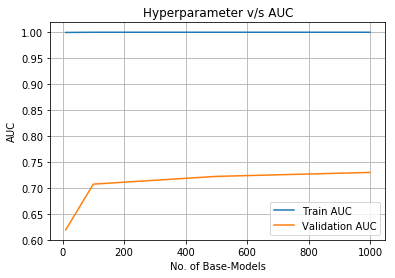

In [202]:
plt.plot(n_estimators,train_auc, label='Train AUC')
plt.plot(n_estimators,cv_auc, label='Validation AUC')
plt.legend()
plt.xlabel("No. of Base-Models")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

##### GridSearchCV (K-fold Cross Validation)

In [203]:
# https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(class_weight='balanced')
grid_params = {'n_estimators' : [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
gs = GridSearchCV(rf, grid_params, cv=3, scoring='roc_auc')
gs_results = gs.fit(x_tr, y_train)
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

0.6994990701937641
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
{'max_depth': 10, 'n_estimators': 1000}


In [204]:
print('Best score: ',gs_results.best_score_)
print('k value with best score: ',gs_results.best_params_)
print('='*75)
print('Train AUC scores')
print(gs.cv_results_['mean_train_score'])
print('CV AUC scores')
print(gs.cv_results_['mean_test_score'])

Best score:  0.6994990701937641
k value with best score:  {'max_depth': 10, 'n_estimators': 1000}
Train AUC scores
[0.59499604 0.67174889 0.69216614 0.70203384 0.70498399 0.70906446
 0.71494658 0.71312032 0.63160537 0.70312655 0.71151179 0.71367852
 0.72165899 0.72548913 0.72741352 0.72785226 0.64543826 0.71468987
 0.728073   0.73385463 0.73575626 0.7357077  0.74132843 0.74166119
 0.66636943 0.73480949 0.74095989 0.7500047  0.75330954 0.75549492
 0.75756057 0.75634671 0.68335175 0.74993667 0.76806473 0.7675772
 0.76707753 0.77248384 0.77496929 0.77675371 0.69965531 0.76671538
 0.78431421 0.78828631 0.78951885 0.79077088 0.79285597 0.79364889
 0.71599131 0.78918066 0.79886728 0.80682017 0.8075702  0.81272126
 0.8134592  0.81391926 0.7302829  0.80503295 0.81691659 0.82452027
 0.82614583 0.8289325  0.83083484 0.83312095 0.7463613  0.82455484
 0.83657429 0.84595835 0.8482483  0.84847183 0.85080237 0.85059933]
CV AUC scores
[0.58091048 0.64774957 0.66846319 0.67401859 0.67857086 0.68215036


##### 3D Scatter Plot and Heatmap for Train AUC

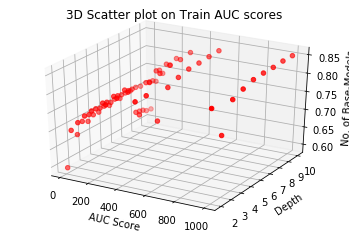

In [206]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_train_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

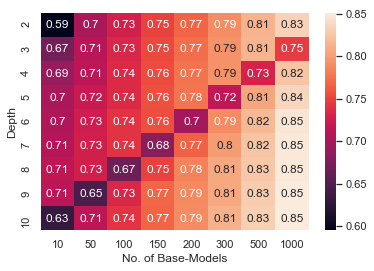

In [208]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

##### 3D Scatter Plot and Heatmap for CV AUC

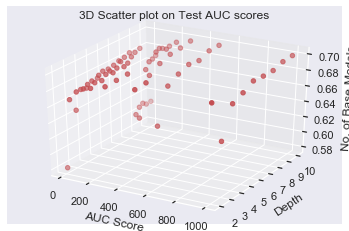

In [209]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_test_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Test AUC scores')
plt.show()

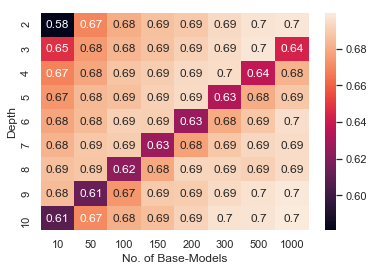

In [210]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

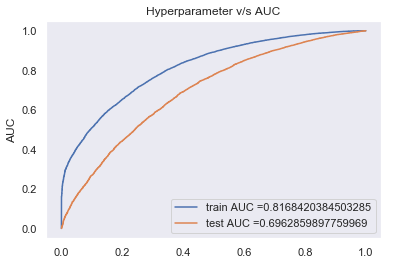

In [211]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

rf = RandomForestClassifier(max_depth = 10, n_estimators = 1000,class_weight='balanced')
rf.fit(x_tr,y_train)
    
y_train_pred = pred_prob(rf,x_tr)
y_test_pred = pred_prob(rf,x_te)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
# plt.xlabel("Lambda Inverse: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

In [98]:
#https://github.com/harrismohammed/DonorsChoose.org---NaiveBayes/blob/master/DonorsChoose_NB.ipynb

def pred_prob_label(proba,thresholds,tpr,fpr): 
    
    t = thresholds[np.argmax(tpr*(1-fpr))]
    prob_pred = [];
    for i in proba:
        if i > t:
            prob_pred.append(1)
        else:
            prob_pred.append(0)
    return prob_pred

Train Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.75      0.45      7426
           1       0.94      0.71      0.81     41615

   micro avg       0.72      0.72      0.72     49041
   macro avg       0.63      0.73      0.63     49041
weighted avg       0.85      0.72      0.76     49041

Train Confusion Matrix:
[[ 5563  1863]
 [11898 29717]]


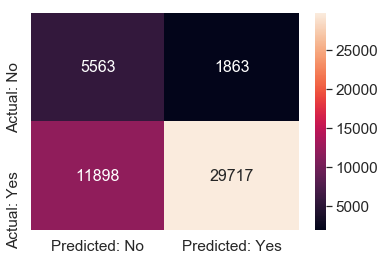

In [213]:
#https://medium.com/datadriveninvestor/simplifying-the-confusion-matrix-aa1fa0b0fc35

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_train_pred_labels = pred_prob_label(y_train_pred,tr_thresholds,train_tpr,train_fpr)
y_test_pred_labels = pred_prob_label(y_test_pred,te_thresholds,test_tpr,test_fpr)

class_report_train = classification_report(y_train, y_train_pred_labels)
class_report_test = classification_report(y_test, y_test_pred_labels)

df_cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Train Classification Report:')
print(class_report_train)
print('Train Confusion Matrix:')
print(confusion_matrix(y_train, y_train_pred_labels))



Test Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.61      0.36      5459
           1       0.91      0.68      0.78     30593

   micro avg       0.67      0.67      0.67     36052
   macro avg       0.58      0.65      0.57     36052
weighted avg       0.81      0.67      0.72     36052

Test Confusion Matrix:


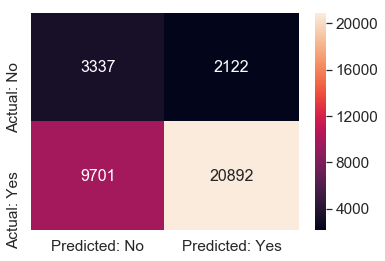

In [214]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Test Classification Report:')
print(class_report_test)
print('Test Confusion Matrix:')

### 2. Set 2: categorical, numerical features + project_title(TFIDF) + preprocessed_essay TFIDF with bi-grams with min_df=10 and max_features=5000)

In [99]:
from scipy.sparse import hstack

x_tr_2 = hstack((cat_0_train, cat_1_train, subcat_0_train, subcat_1_train,state_0_train, state_1_train, 
               proj_grade_0_train, proj_grade_1_train, teacher_prefix_0_train, teacher_prefix_1_train, 
               x_train_price_standardized, x_train_essays_tfidf,x_train_titles_tfidf)).tocsr()

x_cv_2 = hstack((cat_0_cv, cat_1_cv, subcat_0_cv, subcat_1_cv, state_0_cv, state_1_cv,
               proj_grade_0_cv, proj_grade_1_cv, teacher_prefix_0_cv, teacher_prefix_1_cv, 
               x_cv_price_standardized,x_cv_essays_tfidf, x_cv_titles_tfidf)).tocsr()

x_te_2 = hstack((cat_0_test, cat_1_test, subcat_0_test, subcat_1_test, state_0_test, state_1_test,
               proj_grade_0_test, proj_grade_1_test, teacher_prefix_0_test, teacher_prefix_1_test,
               x_test_price_standardized,x_test_essays_tfidf, x_test_titles_tfidf)).tocsr()


print("Final Data matrix")
print(x_tr_2.shape, y_train.shape)
print(x_cv_2.shape, y_cv.shape)
print(x_te_2.shape, y_test.shape)

Final Data matrix
(49041, 6989) (49041,)
(24155, 6989) (24155,)
(36052, 6989) (36052,)


In [216]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import math
import matplotlib.pyplot as plt

n_estimators = [10, 100, 500, 1000]
train_auc = []
cv_auc = []

for i in n_estimators:
    rf = RandomForestClassifier(class_weight = 'balanced', n_estimators = i)
    rf.fit(x_tr_2,y_train)
    
    y_train_pred = pred_prob(rf,x_tr_2)
    y_cv_pred = pred_prob(rf,x_cv_2)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

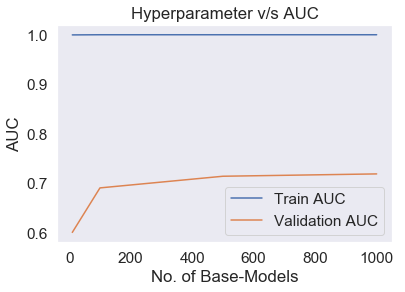

In [217]:
plt.plot(n_estimators,train_auc, label='Train AUC')
plt.plot(n_estimators,cv_auc, label='Validation AUC')
plt.legend()
plt.xlabel("No. of Base-Models")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

#####  GridSearchCV (K-fold Cross Validation)

In [218]:
# https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(class_weight='balanced')
grid_params = {'n_estimators' : [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
gs = GridSearchCV(rf, grid_params, cv=3, scoring='roc_auc')
gs_results = gs.fit(x_tr_2, y_train)
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

0.6988804028532518
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
{'max_depth': 10, 'n_estimators': 1000}


In [219]:
print('Best score: ',gs_results.best_score_)
print('k value with best score: ',gs_results.best_params_)
print('='*75)
print('Train AUC scores')
print(gs.cv_results_['mean_train_score'])
print('CV AUC scores')
print(gs.cv_results_['mean_test_score'])

Best score:  0.6988804028532518
k value with best score:  {'max_depth': 10, 'n_estimators': 1000}
Train AUC scores
[0.6193495  0.67756249 0.6980059  0.70033134 0.71193001 0.71383596
 0.71525896 0.71888608 0.63092609 0.70468171 0.72339509 0.72128371
 0.72960924 0.72990319 0.7298432  0.73327973 0.66362717 0.72699544
 0.73901575 0.73946437 0.7434266  0.74418175 0.74800005 0.74953004
 0.68347583 0.74595757 0.7591345  0.75936122 0.76155273 0.76651174
 0.76961549 0.76825116 0.68996095 0.76234714 0.77529304 0.78098944
 0.78244871 0.78609891 0.78886512 0.78943365 0.71672838 0.78442534
 0.79843199 0.79895594 0.80221054 0.80939485 0.80650546 0.80968923
 0.73186696 0.79961185 0.81803874 0.82081921 0.82326529 0.82521649
 0.82911446 0.82939976 0.7462662  0.82325642 0.84058337 0.84324918
 0.8416903  0.84758063 0.85107428 0.85166624 0.76667278 0.84575291
 0.85908158 0.85862436 0.86920588 0.869142   0.871287   0.87249792]
CV AUC scores
[0.60053043 0.64189792 0.66469816 0.66522397 0.67977172 0.67983586

##### 3D Scatter Plot and Heatmap for Train AUC

In [220]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_train_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

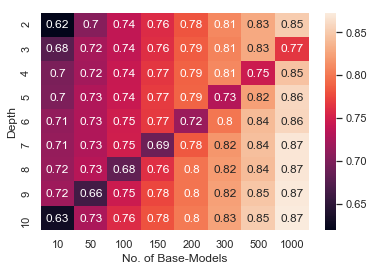

In [221]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

##### 3D Scatter Plot and Heatmap for CV AUC

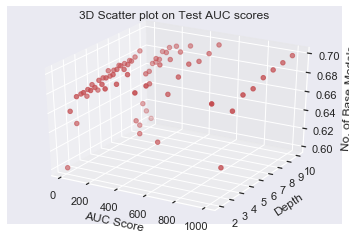

In [222]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_test_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Test AUC scores')
plt.show()

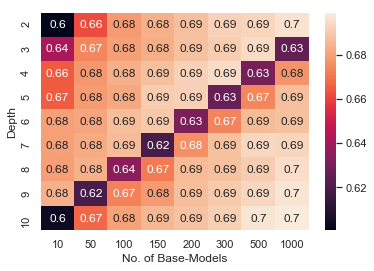

In [223]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

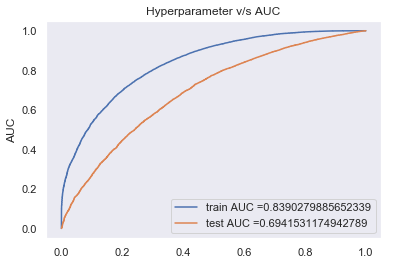

In [224]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

rf = RandomForestClassifier(max_depth = 10, n_estimators = 1000,class_weight='balanced')
rf.fit(x_tr_2,y_train)
    
y_train_pred_2 = pred_prob(rf,x_tr_2)
y_test_pred_2 = pred_prob(rf,x_te_2)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_2)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_2)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
# plt.xlabel("Lambda Inverse: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

Train Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.75      0.48      7426
           1       0.94      0.75      0.84     41615

   micro avg       0.75      0.75      0.75     49041
   macro avg       0.65      0.75      0.66     49041
weighted avg       0.85      0.75      0.78     49041

Train Confusion Matrix:


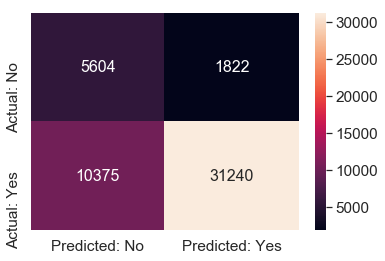

In [225]:
#### https://medium.com/datadriveninvestor/simplifying-the-confusion-matrix-aa1fa0b0fc35

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_train_pred_labels = pred_prob_label(y_train_pred_2,tr_thresholds,train_tpr,train_fpr)
y_test_pred_labels = pred_prob_label(y_test_pred_2,te_thresholds,test_tpr,test_fpr)

class_report_train = classification_report(y_train, y_train_pred_labels)
class_report_test = classification_report(y_test, y_test_pred_labels)

df_cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Train Classification Report:')
print(class_report_train)
print('Train Confusion Matrix:')



Test Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.61      0.36      5459
           1       0.91      0.68      0.78     30593

   micro avg       0.67      0.67      0.67     36052
   macro avg       0.58      0.64      0.57     36052
weighted avg       0.81      0.67      0.72     36052

Test Confusion Matrix:


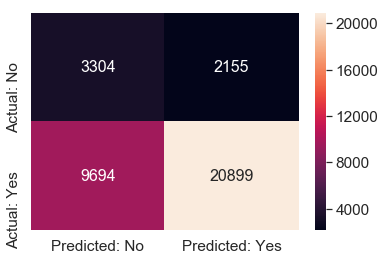

In [226]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Test Classification Report:')
print(class_report_test)
print('Test Confusion Matrix:')

### 3. Set 3: categorical, numerical features + project_title(Avg W2V) + preprocessed_essay (Avg W2V)

In [100]:
from scipy import sparse



In [101]:
from scipy.sparse import hstack

train_w2v_vectors_titles = np.array(x_train_titles_w2v_vectors)
test_w2v_vectors_titles = np.array(x_test_titles_w2v_vectors)
cv_w2v_vectors_titles = np.array(x_cv_titles_w2v_vectors)

train_w2v_vectors_essays = np.array(x_train_essays_w2v_vectors)
test_w2v_vectors_essays = np.array(x_test_essays_w2v_vectors)
cv_w2v_vectors_essays = np.array(x_cv_essays_w2v_vectors)

# print(train_w2v_vectors_essays.shape)
# print(cat_0_train.shape)

x_tr_3 = hstack((
                 sparse.csr_matrix(cat_0_train)[0:40000,:], sparse.csr_matrix(subcat_0_train)[0:40000,:],
                 sparse.csr_matrix(cat_1_train)[0:40000,:], sparse.csr_matrix(subcat_1_train)[0:40000,:],
                 sparse.csr_matrix(state_0_train)[0:40000,:],sparse.csr_matrix(state_1_train)[0:40000,:],
                 sparse.csr_matrix(proj_grade_0_train)[0:40000,:],
                 sparse.csr_matrix(proj_grade_1_train)[0:40000,:], sparse.csr_matrix(teacher_prefix_0_train)[0:40000,:],
                 sparse.csr_matrix(teacher_prefix_1_train)[0:40000,:], sparse.csr_matrix(x_train_price_standardized)[0:40000,:],
                 sparse.csr_matrix(train_w2v_vectors_essays)[0:40000,:], sparse.csr_matrix(train_w2v_vectors_titles)[0:40000,:]
                )).tocsr()

x_cv_3 = hstack((sparse.csr_matrix(cat_0_cv)[0:20000,:], sparse.csr_matrix(cat_1_cv)[0:20000,:],
                 sparse.csr_matrix(subcat_0_cv)[0:20000,:], sparse.csr_matrix(subcat_1_cv)[0:20000,:],
                 sparse.csr_matrix(state_0_cv)[0:20000,:], sparse.csr_matrix(state_1_cv)[0:20000,:], 
                 sparse.csr_matrix(proj_grade_0_cv)[0:20000,:], sparse.csr_matrix(proj_grade_1_cv)[0:20000,:],
                 sparse.csr_matrix(teacher_prefix_0_cv)[0:20000,:], sparse.csr_matrix(teacher_prefix_1_cv)[0:20000,:],
                 x_cv_price_standardized[0:20000,:], cv_w2v_vectors_essays[0:20000,:],cv_w2v_vectors_titles[0:20000,:])).tocsr()

x_te_3 = hstack((sparse.csr_matrix(cat_0_test)[0:30000,:], sparse.csr_matrix(cat_1_test)[0:30000,:],
                 sparse.csr_matrix(subcat_0_test)[0:30000,:], sparse.csr_matrix(subcat_1_test)[0:30000,:],
                 state_0_test[0:30000,:], state_1_test[0:30000,:], proj_grade_0_test[0:30000,:],
                 sparse.csr_matrix(proj_grade_1_test)[0:30000,:], sparse.csr_matrix(teacher_prefix_0_test)[0:30000,:],
                 sparse.csr_matrix(teacher_prefix_1_test)[0:30000,:], x_test_price_standardized[0:30000,:],
                 test_w2v_vectors_essays[0:30000,:],  test_w2v_vectors_titles[0:30000,:])).tocsr()


print("Final Data matrix")
print(x_tr_3.shape, y_train.shape)
print(x_cv_3.shape, y_cv.shape)
print(x_te_3.shape, y_test.shape)

Final Data matrix
(40000, 611) (49041,)
(20000, 611) (24155,)
(30000, 611) (36052,)


In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import math
import matplotlib.pyplot as plt

n_estimators = [10, 100, 500, 1000]
train_auc = []
cv_auc = []

for i in n_estimators:
    rf = RandomForestClassifier(class_weight = 'balanced', n_estimators = i)
    rf.fit(x_tr_3,y_train[:40000])
    
    y_train_pred = pred_prob(rf,x_tr_3)
    y_cv_pred = pred_prob(rf,x_cv_3)
    
    train_auc.append(roc_auc_score(y_train[:40000],y_train_pred))
    cv_auc.append(roc_auc_score(y_cv[:20000],y_cv_pred))

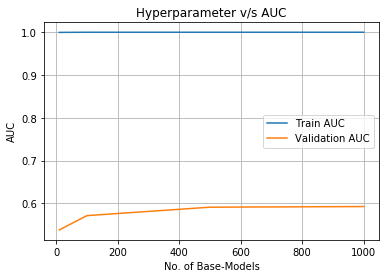

In [103]:
plt.plot(n_estimators,train_auc, label='Train AUC')
plt.plot(n_estimators,cv_auc, label='Validation AUC')
plt.legend()
plt.xlabel("No. of Base-Models")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

##### GridSearchCV (K-fold Cross Validation)

In [104]:
# https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(class_weight = 'balanced')
grid_params = {'n_estimators' : [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
gs = GridSearchCV(rf, grid_params, cv=3, scoring='roc_auc')
gs_results = gs.fit(x_tr_3, y_train[:40000])
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

0.6027548623284024
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
{'max_depth': 7, 'n_estimators': 300}


In [105]:
print('Best score: ',gs_results.best_score_)
print('k value with best score: ',gs_results.best_params_)
print('='*75)
print('Train AUC scores')
print(gs.cv_results_['mean_train_score'])
print('CV AUC scores')
print(gs.cv_results_['mean_test_score'])

Best score:  0.6027548623284024
k value with best score:  {'max_depth': 7, 'n_estimators': 300}
Train AUC scores
[0.59727865 0.59846935 0.59972123 0.60655203 0.6013691  0.60111242
 0.60481892 0.60177678 0.60552248 0.6210379  0.61825436 0.61905679
 0.62024683 0.62077311 0.6188186  0.62012829 0.64152139 0.64747243
 0.64624202 0.64664651 0.64710921 0.64717826 0.64664188 0.64608036
 0.66625453 0.68546199 0.68592399 0.68934987 0.68640154 0.6877419
 0.68875119 0.68853864 0.7024046  0.73909913 0.74215767 0.74413496
 0.7447827  0.74472335 0.74643453 0.74646413 0.7556279  0.80301364
 0.80870561 0.81481091 0.81444651 0.81609599 0.81815052 0.81835815
 0.81072019 0.87212242 0.88157638 0.88302218 0.88561637 0.88812963
 0.8886983  0.89016795 0.86200178 0.92507576 0.93883289 0.94167299
 0.94278997 0.94450043 0.94493775 0.94734834 0.90016505 0.96490933
 0.9727343  0.97574753 0.97643729 0.97952792 0.97962931 0.98095641]
CV AUC scores
[0.58372591 0.58455616 0.58611404 0.59169525 0.58802964 0.58737288
 0

##### 3D Scatter Plot and Heatmap for Train AUC

In [106]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_train_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [108]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

##### 3D Scatter Plot and Heatmap for CV AUC

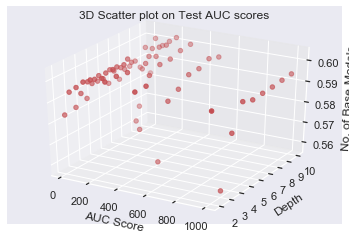

In [109]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_test_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Test AUC scores')
plt.show()

In [110]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

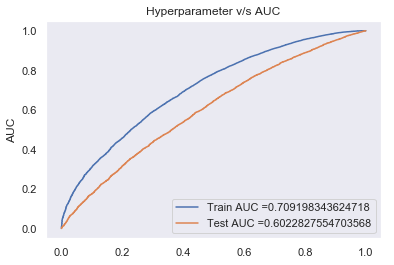

In [111]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

rf = RandomForestClassifier(max_depth = 6, n_estimators = 500,class_weight='balanced')
rf.fit(x_tr_3,y_train[:40000])
    
y_train_pred_3 = pred_prob(rf,x_tr_3)
y_test_pred_3 = pred_prob(rf,x_te_3)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train[0:40000], y_train_pred_3)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test[0:30000], y_test_pred_3)

plt.close()
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
# plt.xlabel("Lambda Inverse: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

Train Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.65      0.35      6039
           1       0.91      0.64      0.75     33961

   micro avg       0.64      0.64      0.64     40000
   macro avg       0.58      0.65      0.55     40000
weighted avg       0.81      0.64      0.69     40000

Train Confusion Matrix:


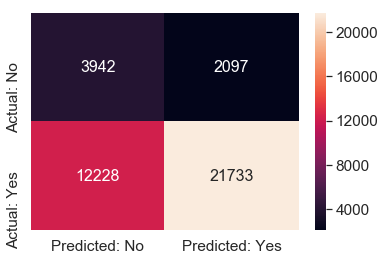

In [112]:
#https://medium.com/datadriveninvestor/simplifying-the-confusion-matrix-aa1fa0b0fc35

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_train_pred_labels = pred_prob_label(y_train_pred_3,tr_thresholds,train_tpr,train_fpr)
y_test_pred_labels = pred_prob_label(y_test_pred_3,tr_thresholds,train_tpr,train_fpr)

confusion_mat_train = confusion_matrix(y_train[0:40000], y_train_pred_labels)
confusion_mat_test = confusion_matrix(y_test[0:30000], y_test_pred_labels)

class_report_train = classification_report(y_train[0:40000], y_train_pred_labels)
class_report_test = classification_report(y_test[0:30000], y_test_pred_labels)

df_cm = pd.DataFrame(confusion_matrix(y_train[0:40000], y_train_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Train Classification Report:')
print(class_report_train)
print('Train Confusion Matrix:')

Test Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.52      0.28      4484
           1       0.88      0.62      0.73     25516

   micro avg       0.60      0.60      0.60     30000
   macro avg       0.54      0.57      0.50     30000
weighted avg       0.78      0.60      0.66     30000

Test Confusion Matrix:


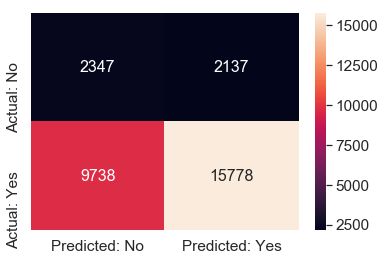

In [113]:
df_cm = pd.DataFrame(confusion_matrix(y_test[0:30000], y_test_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Test Classification Report:')
print(class_report_test)
print('Test Confusion Matrix:')

### Set 4: categorical, numerical features + project_title(TFIDF weighted W2V) + preprocessed_essay (TFIDF weighted W2V)

In [114]:
from scipy.sparse import hstack

train_tfidf_w2v_vectors_titles = np.array(x_train_titles_tfidf_w2v_vectors)
test_tfidf_w2v_vectors_titles = np.array(x_test_titles_tfidf_w2v_vectors)
cv_tfidf_w2v_vectors_titles = np.array(x_cv_titles_tfidf_w2v_vectors)

train_tfidf_w2v_vectors_essays = np.array(x_train_essays_tfidf_w2v_vectors)
test_tfidf_w2v_vectors_essays = np.array(x_test_essays_tfidf_w2v_vectors)
cv_tfidf_w2v_vectors_essays = np.array(x_cv_essays_tfidf_w2v_vectors)

x_tr_4 = hstack((
                 sparse.csr_matrix(cat_0_train)[0:40000,:], sparse.csr_matrix(subcat_0_train)[0:40000,:],
                 sparse.csr_matrix(cat_1_train)[0:40000,:], sparse.csr_matrix(subcat_1_train)[0:40000,:],
                 sparse.csr_matrix(state_0_train)[0:40000,:],sparse.csr_matrix(state_1_train)[0:40000,:],
                 sparse.csr_matrix(proj_grade_0_train)[0:40000,:],
                 sparse.csr_matrix(proj_grade_1_train)[0:40000,:], sparse.csr_matrix(teacher_prefix_0_train)[0:40000,:],
                 sparse.csr_matrix(teacher_prefix_1_train)[0:40000,:], sparse.csr_matrix(x_train_price_standardized)[0:40000,:],
                 sparse.csr_matrix(train_tfidf_w2v_vectors_essays)[0:40000,:], sparse.csr_matrix(train_tfidf_w2v_vectors_titles)[0:40000,:]
                )).tocsr()

x_cv_4 = hstack((sparse.csr_matrix(cat_0_cv)[0:20000,:], sparse.csr_matrix(cat_1_cv)[0:20000,:],
                 sparse.csr_matrix(subcat_0_cv)[0:20000,:], sparse.csr_matrix(subcat_1_cv)[0:20000,:],
                 sparse.csr_matrix(state_0_cv)[0:20000,:], sparse.csr_matrix(state_1_cv)[0:20000,:], 
                 sparse.csr_matrix(proj_grade_0_cv)[0:20000,:], sparse.csr_matrix(proj_grade_1_cv)[0:20000,:],
                 sparse.csr_matrix(teacher_prefix_0_cv)[0:20000,:], sparse.csr_matrix(teacher_prefix_1_cv)[0:20000,:],
                 x_cv_price_standardized[0:20000,:], cv_tfidf_w2v_vectors_essays[0:20000,:],cv_tfidf_w2v_vectors_titles[0:20000,:])).tocsr()

x_te_4 = hstack((sparse.csr_matrix(cat_0_test)[0:30000,:], sparse.csr_matrix(cat_1_test)[0:30000,:],
                 sparse.csr_matrix(subcat_0_test)[0:30000,:], sparse.csr_matrix(subcat_1_test)[0:30000,:],
                 state_0_test[0:30000,:], state_1_test[0:30000,:], proj_grade_0_test[0:30000,:],
                 sparse.csr_matrix(proj_grade_1_test)[0:30000,:], sparse.csr_matrix(teacher_prefix_0_test)[0:30000,:],
                 sparse.csr_matrix(teacher_prefix_1_test)[0:30000,:], x_test_price_standardized[0:30000,:],
                 test_tfidf_w2v_vectors_essays[0:30000,:],  test_tfidf_w2v_vectors_titles[0:30000,:])).tocsr()


print("Final Data matrix")
print(x_tr_4.shape, y_train.shape)
print(x_cv_4.shape, y_cv.shape)
print(x_te_4.shape, y_test.shape)

Final Data matrix
(40000, 611) (49041,)
(20000, 611) (24155,)
(30000, 611) (36052,)


In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import math
import matplotlib.pyplot as plt

n_estimators = [10, 100, 500, 1000]
train_auc = []
cv_auc = []

for i in n_estimators:
    rf = RandomForestClassifier(class_weight = 'balanced', n_estimators = i)
    rf.fit(x_tr_4,y_train[0:40000])
    
    y_train_pred = pred_prob(rf,x_tr_4)
    y_cv_pred = pred_prob(rf,x_cv_4)
    
    train_auc.append(roc_auc_score(y_train[0:40000],y_train_pred))
    cv_auc.append(roc_auc_score(y_cv[0:20000],y_cv_pred))

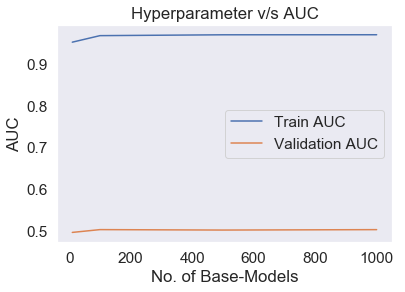

In [116]:
plt.plot(n_estimators,train_auc, label='Train AUC')
plt.plot(n_estimators,cv_auc, label='Validation AUC')
plt.legend()
plt.xlabel("No. of Base-Models")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

##### GridSearchCV (K-fold Cross Validation)

In [128]:
# https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(class_weight='balanced')
grid_params = {'n_estimators' : [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
gs = GridSearchCV(rf, grid_params, cv=3, scoring='roc_auc')
gs_results = gs.fit(x_tr_4, y_train[0:40000])
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

0.5929299313481248
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
{'max_depth': 7, 'n_estimators': 500}


In [129]:
print('Best score: ',gs_results.best_score_)
print('k value with best score: ',gs_results.best_params_)
print('='*75)
print('Train AUC scores')
print(gs.cv_results_['mean_train_score'])
print('CV AUC scores')
print(gs.cv_results_['mean_test_score'])

Best score:  0.5929299313481248
k value with best score:  {'max_depth': 7, 'n_estimators': 500}
Train AUC scores
[0.5857955  0.58748063 0.5875453  0.58759554 0.5874022  0.58736569
 0.58724613 0.5871549  0.5919673  0.59478396 0.59527512 0.59694466
 0.5968024  0.59696993 0.59778712 0.59825914 0.59969502 0.60487248
 0.60598197 0.60661371 0.60708967 0.60665387 0.6074815  0.6080503
 0.60881223 0.61528468 0.6159035  0.61709823 0.61788781 0.61738853
 0.61880146 0.6192028  0.62431736 0.62727689 0.62922338 0.63087499
 0.63083796 0.63105993 0.63167433 0.63277465 0.63599808 0.64357916
 0.64590038 0.64694564 0.64759755 0.64779329 0.64800048 0.64788059
 0.65460308 0.66273347 0.66501868 0.66623609 0.66722899 0.6666342
 0.66717365 0.66790347 0.67487979 0.68477683 0.68785226 0.68862506
 0.68953088 0.68999089 0.68990447 0.68990795 0.68746996 0.71194366
 0.71397503 0.71594069 0.71492095 0.71578496 0.71601845 0.71662811]
CV AUC scores
[0.58418706 0.58548187 0.58572615 0.58579231 0.58584569 0.58550134
 0.

##### 3D Scatter Plot and Heatmap for Train AUC 

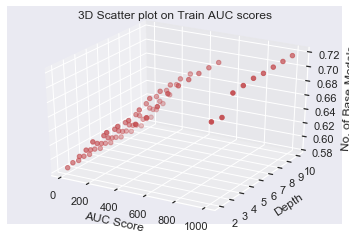

In [130]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_train_score'])


ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [131]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

##### 3D Scatter Plot and Heatmap for CV AUC

In [132]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_test_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_xlabel('AUC Score')
ax.set_ylabel('Depth')
ax.set_zlabel('No. of Base-Models')

plt.title('3D Scatter plot on CV AUC scores')
plt.show()

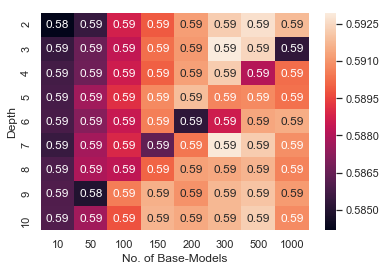

In [133]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

In [134]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

rf = RandomForestClassifier(max_depth = 7, n_estimators = 500 ,class_weight='balanced')
rf.fit(x_tr_4,y_train[:40000])
    
y_train_pred_4 = pred_prob(rf,x_tr_4)
y_test_pred_4 = pred_prob(rf,x_te_4)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train[0:40000], y_train_pred_4)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test[0:30000], y_test_pred_4)

plt.close()
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
# plt.xlabel("Lambda Inverse: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

Train Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.60      0.31      6039
           1       0.89      0.58      0.71     33961

   micro avg       0.59      0.59      0.59     40000
   macro avg       0.55      0.59      0.51     40000
weighted avg       0.79      0.59      0.65     40000

Train Confusion Matrix:


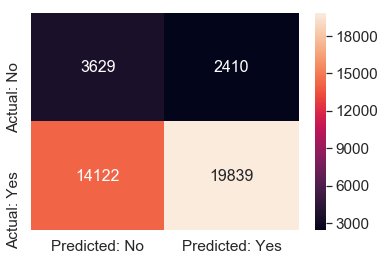

In [135]:
#https://medium.com/datadriveninvestor/simplifying-the-confusion-matrix-aa1fa0b0fc35

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_train_pred_labels = pred_prob_label(y_train_pred_4,tr_thresholds,train_tpr,train_fpr)
y_test_pred_labels = pred_prob_label(y_test_pred_4,tr_thresholds,train_tpr,train_fpr)

confusion_mat_train = confusion_matrix(y_train[0:40000], y_train_pred_labels)
confusion_mat_test = confusion_matrix(y_test[0:30000], y_test_pred_labels)

class_report_train = classification_report(y_train[0:40000], y_train_pred_labels)
class_report_test = classification_report(y_test[0:30000], y_test_pred_labels)

df_cm = pd.DataFrame(confusion_matrix(y_train[0:40000], y_train_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Train Classification Report:')
print(class_report_train)
print('Train Confusion Matrix:')

Test Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.56      0.28      4484
           1       0.88      0.58      0.70     25516

   micro avg       0.58      0.58      0.58     30000
   macro avg       0.53      0.57      0.49     30000
weighted avg       0.78      0.58      0.64     30000

Test Confusion Matrix:


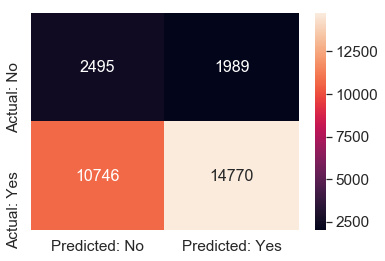

In [136]:
df_cm = pd.DataFrame(confusion_matrix(y_test[0:30000], y_test_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Test Classification Report:')
print(class_report_test)
print('Test Confusion Matrix:')

## 5. Apply Gradient Boosted Decision Tree Classification

### 1. Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW with bi-grams with min_df=10 and max_features=5000)

In [138]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import math
import matplotlib.pyplot as plt

n_estimators = [10, 100, 500, 1000]
train_auc = []
cv_auc = []

for i in n_estimators:
    gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', max_depth = 5, n_estimators = i)
    gbdt.fit(x_tr,y_train)
    
    y_train_pred = pred_prob(gbdt,x_tr)
    y_cv_pred = pred_prob(gbdt,x_cv)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



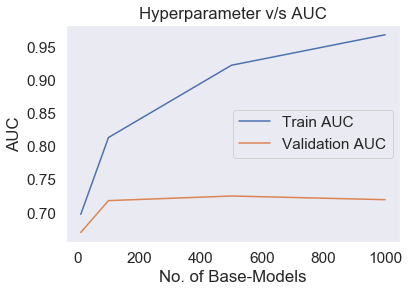

In [139]:
plt.plot(n_estimators,train_auc, label='Train AUC')
plt.plot(n_estimators,cv_auc, label='Validation AUC')
plt.legend()
plt.xlabel("No. of Base-Models")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

##### GridSearchCV (K-fold Cross Validation)

In [140]:
# https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

from sklearn.model_selection import GridSearchCV

gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced')
grid_params = {'n_estimators' : [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
gs = GridSearchCV(gbdt, grid_params, cv=3, scoring='roc_auc')
gs_results = gs.fit(x_tr, y_train)
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

0.7196411986630183
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=2, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)
{'max_depth': 2, 'n_estimators': 1000}


In [141]:
print('Best score: ',gs_results.best_score_)
print('k value with best score: ',gs_results.best_params_)
print('='*75)
print('Train AUC scores')
print(gs.cv_results_['mean_train_score'])
print('CV AUC scores')
print(gs.cv_results_['mean_test_score'])

Best score:  0.7196411986630183
k value with best score:  {'max_depth': 2, 'n_estimators': 1000}
Train AUC scores
[0.64382997 0.69358563 0.7226236  0.74120693 0.75486751 0.77558662
 0.805198   0.85032938 0.66499439 0.7249415  0.76109863 0.78405547
 0.80172578 0.82881971 0.86573745 0.92087882 0.68455577 0.75830509
 0.79933227 0.82643759 0.84634688 0.87660931 0.91594471 0.96459918
 0.70532143 0.79203215 0.8366036  0.86539621 0.88641071 0.91557503
 0.95078715 0.9864859  0.71976024 0.81819203 0.86724718 0.89626318
 0.91657813 0.94285765 0.97284821 0.99578521 0.72277633 0.82883016
 0.88219034 0.91296171 0.93330632 0.95876095 0.98396272 0.99870951
 0.72635254 0.83349552 0.89092827 0.92238675 0.9428591  0.96825907
 0.98976585 0.99963262 0.72781801 0.83676457 0.89314611 0.92614705
 0.94729105 0.97287893 0.9927898  0.99983789 0.72975522 0.83843575
 0.89720662 0.92955536 0.95100367 0.97607638 0.99426779 0.99993162]
CV AUC scores
[0.63558747 0.67641696 0.69357354 0.70286662 0.70842415 0.71460697


##### 3D Scatter Plot and Heatmap for Train AUC

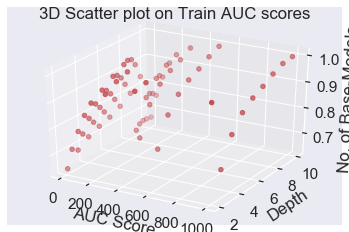

In [142]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_train_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')


ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [144]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

##### 3D Scatter Plot and Heatmap for CV AUC

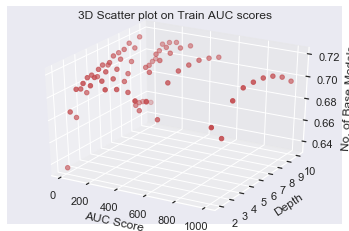

In [145]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_test_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

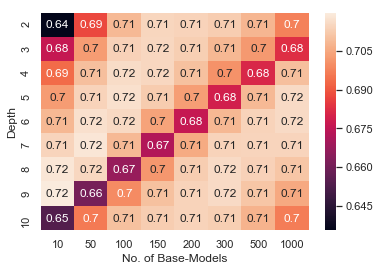

In [146]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

##### 3D Scatter Plot and Heatmap for Train AUC

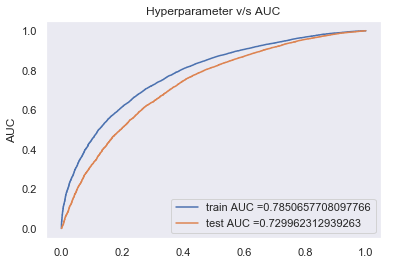

In [147]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', max_depth = 2, n_estimators = 500)
gbdt.fit(x_tr,y_train)
    
y_train_pred = pred_prob(gbdt,x_tr)
y_test_pred = pred_prob(gbdt,x_te)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
# plt.xlabel("Lambda Inverse: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

Train Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.72      0.43      7426
           1       0.93      0.70      0.80     41615

   micro avg       0.71      0.71      0.71     49041
   macro avg       0.62      0.71      0.62     49041
weighted avg       0.84      0.71      0.75     49041

Train Confusion Matrix:
[[ 5378  2048]
 [12282 29333]]


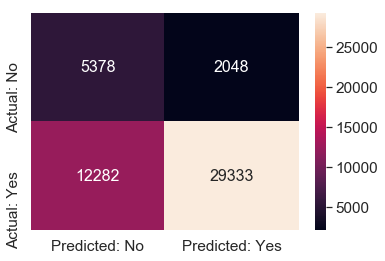

In [148]:
#https://medium.com/datadriveninvestor/simplifying-the-confusion-matrix-aa1fa0b0fc35

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_train_pred_labels = pred_prob_label(y_train_pred,tr_thresholds,train_tpr,train_fpr)
y_test_pred_labels = pred_prob_label(y_test_pred,te_thresholds,test_tpr,test_fpr)

class_report_train = classification_report(y_train, y_train_pred_labels)
class_report_test = classification_report(y_test, y_test_pred_labels)

df_cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Train Classification Report:')
print(class_report_train)
print('Train Confusion Matrix:')
print(confusion_matrix(y_train, y_train_pred_labels))



Test Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.64      0.39      5459
           1       0.92      0.70      0.80     30593

   micro avg       0.69      0.69      0.69     36052
   macro avg       0.60      0.67      0.59     36052
weighted avg       0.82      0.69      0.73     36052

Test Confusion Matrix:


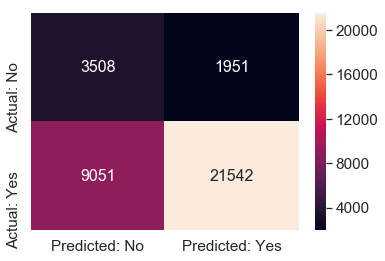

In [149]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Test Classification Report:')
print(class_report_test)
print('Test Confusion Matrix:')

### 2. Set 2: categorical, numerical features + project_title(TFIDF) + preprocessed_essay TFIDF with bi-grams with min_df=10 and max_features=5000)

In [150]:
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import math
import matplotlib.pyplot as plt

n_estimators = [10, 100, 500, 1000]
train_auc = []
cv_auc = []

for i in n_estimators:
    gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', max_depth = 5, n_estimators = i)
    gbdt.fit(x_tr_2,y_train)
    
    y_train_pred = pred_prob(gbdt,x_tr_2)
    y_cv_pred = pred_prob(gbdt,x_cv_2)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

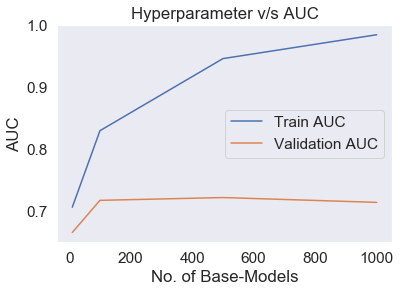

In [151]:
plt.plot(n_estimators,train_auc, label='Train AUC')
plt.plot(n_estimators,cv_auc, label='Validation AUC')
plt.legend()
plt.xlabel("No. of Base-Models")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

##### GridSearchCV (K-fold Cross Validation)

In [152]:
# https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

from sklearn.model_selection import GridSearchCV

gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced')
grid_params = {'n_estimators' : [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
gs = GridSearchCV(gbdt, grid_params, cv=3, scoring='roc_auc')
gs_results = gs.fit(x_tr_2, y_train)
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

0.7161130949461737
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=2, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)
{'max_depth': 2, 'n_estimators': 500}


In [153]:
print('Best score: ',gs_results.best_score_)
print('k value with best score: ',gs_results.best_params_)
print('='*75)
print('Train AUC scores')
print(gs.cv_results_['mean_train_score'])
print('CV AUC scores')
print(gs.cv_results_['mean_test_score'])

Best score:  0.7161130949461737
k value with best score:  {'max_depth': 2, 'n_estimators': 500}
Train AUC scores
[0.64983012 0.69873559 0.73085196 0.75066021 0.76687174 0.79145677
 0.82743578 0.88348577 0.66976077 0.733107   0.77289209 0.79897431
 0.81923647 0.85067886 0.89429454 0.95116331 0.69200276 0.76884885
 0.81483498 0.84402664 0.86677526 0.89955786 0.94101603 0.98315111
 0.71838411 0.80641642 0.85464589 0.88479159 0.90625978 0.93633875
 0.96960356 0.9953961  0.73131428 0.83379309 0.88447007 0.91466428
 0.93603815 0.96125606 0.98538148 0.99886146 0.73660996 0.84667348
 0.8990764  0.93031841 0.94956908 0.97293965 0.99248627 0.99975457
 0.73745083 0.85293339 0.90984802 0.9407354  0.95943571 0.98087634
 0.99588545 0.99993037 0.73668906 0.85682332 0.91630712 0.94830487
 0.96687683 0.9864915  0.99776039 0.99997748 0.73999286 0.85913
 0.91970563 0.95200319 0.97100432 0.98889137 0.99840919 0.99999088]
CV AUC scores
[0.64116156 0.67827499 0.69401489 0.70246641 0.70829644 0.71259058
 0.7

##### 3D Scatter Plot and Heatmap for Train AUC

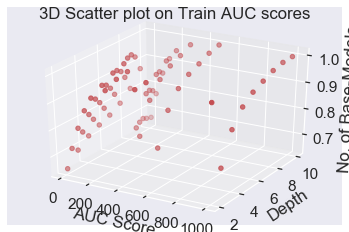

In [154]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_train_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

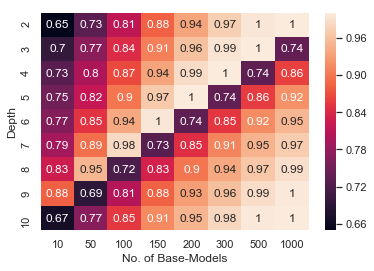

In [155]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

##### 3D Scatter Plot and Heatmap for CV AUC

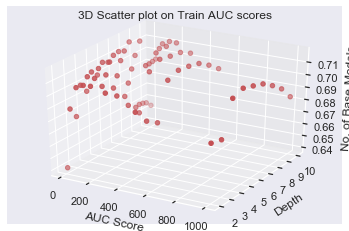

In [156]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_test_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [157]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

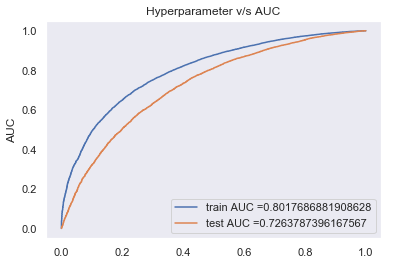

In [158]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', max_depth = 2, n_estimators = 500)
gbdt.fit(x_tr_2,y_train)
    
y_train_pred_2 = pred_prob(gbdt,x_tr_2)
y_test_pred_2 = pred_prob(gbdt,x_te_2)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_2)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_2)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
# plt.xlabel("Lambda Inverse: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

Train Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.75      0.44      7426
           1       0.94      0.71      0.81     41615

   micro avg       0.72      0.72      0.72     49041
   macro avg       0.63      0.73      0.63     49041
weighted avg       0.85      0.72      0.75     49041

Train Confusion Matrix:
[[ 5546  1880]
 [12044 29571]]


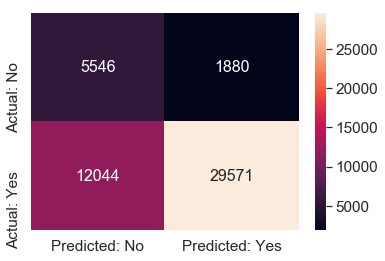

In [159]:
#https://medium.com/datadriveninvestor/simplifying-the-confusion-matrix-aa1fa0b0fc35

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_train_pred_labels = pred_prob_label(y_train_pred_2,tr_thresholds,train_tpr,train_fpr)
y_test_pred_labels = pred_prob_label(y_test_pred_2,te_thresholds,test_tpr,test_fpr)

class_report_train = classification_report(y_train, y_train_pred_labels)
class_report_test = classification_report(y_test, y_test_pred_labels)

df_cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Train Classification Report:')
print(class_report_train)
print('Train Confusion Matrix:')
print(confusion_matrix(y_train, y_train_pred_labels))



In [160]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Test Classification Report:')
print(class_report_test)
print('Test Confusion Matrix:')

Test Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.65      0.38      5459
           1       0.92      0.69      0.79     30593

   micro avg       0.69      0.69      0.69     36052
   macro avg       0.59      0.67      0.59     36052
weighted avg       0.82      0.69      0.73     36052

Test Confusion Matrix:


### 3. Set 3: categorical, numerical features + project_title(Avg W2V) + preprocessed_essay (Avg W2V)

In [161]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import math
import matplotlib.pyplot as plt

n_estimators = [10, 100, 500, 1000]
train_auc = []
cv_auc = []

for i in n_estimators:
    gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', max_depth = 5, n_estimators = i)
    gbdt.fit(x_tr_3,y_train[:40000])
    
    y_train_pred = pred_prob(gbdt,x_tr_3)
    y_cv_pred = pred_prob(gbdt,x_cv_3)
    
    train_auc.append(roc_auc_score(y_train[:40000],y_train_pred))
    cv_auc.append(roc_auc_score(y_cv[:20000],y_cv_pred))

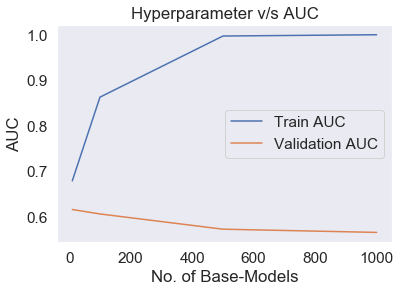

In [162]:
plt.plot(n_estimators,train_auc, label='Train AUC')
plt.plot(n_estimators,cv_auc, label='Validation AUC')
plt.legend()
plt.xlabel("No. of Base-Models")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

##### GridSearchCV (K-fold Cross Validation)

In [163]:
# https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

from sklearn.model_selection import GridSearchCV

gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced')
grid_params = {'n_estimators' : [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
gs = GridSearchCV(gbdt, grid_params, cv=3, scoring='roc_auc')
gs_results = gs.fit(x_tr_3, y_train[:40000])
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

0.6234411693039743
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=2, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=50, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)
{'max_depth': 2, 'n_estimators': 50}


In [164]:
print('Best score: ',gs_results.best_score_)
print('k value with best score: ',gs_results.best_params_)
print('='*75)
print('Train AUC scores')
print(gs.cv_results_['mean_train_score'])
print('CV AUC scores')
print(gs.cv_results_['mean_test_score'])

Best score:  0.6234411693039743
k value with best score:  {'max_depth': 2, 'n_estimators': 50}
Train AUC scores
[0.62535305 0.65525051 0.68162497 0.70310628 0.72207434 0.75467587
 0.80343955 0.88270761 0.63989938 0.69564418 0.74671622 0.78665691
 0.81931099 0.86971977 0.93093401 0.98567305 0.66493187 0.7531092
 0.82887046 0.88210318 0.91776737 0.96020279 0.99108812 0.99987525
 0.70693512 0.82767081 0.91246219 0.95812357 0.97976173 0.9951926
 0.99984832 1.         0.72330844 0.86526202 0.94670621 0.98048515
 0.99312111 0.99910895 0.99999186 1.         0.72841241 0.87539665
 0.9579885  0.98553409 0.99473847 0.99937209 0.99999571 1.
 0.7323279  0.88050023 0.96052846 0.98674774 0.99546318 0.99950512
 0.99999483 1.         0.73156677 0.88443621 0.9621731  0.98802012
 0.99601924 0.99960378 0.99999724 1.         0.73275877 0.88734692
 0.96352828 0.98880577 0.99643064 0.99971022 0.9999985  1.        ]
CV AUC scores
[0.61485804 0.62344117 0.62327056 0.62221995 0.62161326 0.61856608
 0.61334772 

#### 3D Scatter Plot and Heatmap for Train AUC

In [165]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_train_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [166]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

##### 3D Scatter Plot and Heatmap for CV AUC

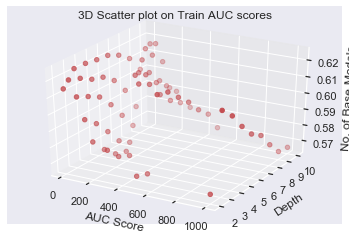

In [167]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_test_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [168]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

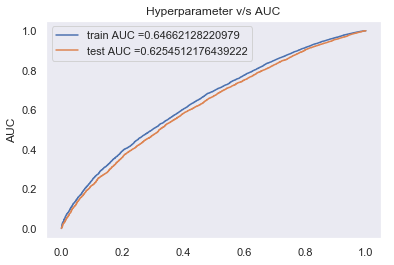

In [170]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced',max_depth = 2, n_estimators = 50)
gbdt.fit(x_tr_3,y_train[:40000])
    
y_train_pred_3 = pred_prob(gbdt,x_tr_3)
y_test_pred_3 = pred_prob(gbdt,x_te_3)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train[:40000], y_train_pred_3)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test[:30000], y_test_pred_3)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
# plt.xlabel("Lambda Inverse: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

Train Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.60      0.31      6039
           1       0.89      0.60      0.72     33961

   micro avg       0.60      0.60      0.60     40000
   macro avg       0.55      0.60      0.52     40000
weighted avg       0.79      0.60      0.66     40000

Train Confusion Matrix:
[[ 3643  2396]
 [13571 20390]]


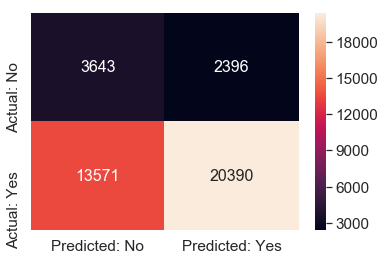

In [171]:
#https://medium.com/datadriveninvestor/simplifying-the-confusion-matrix-aa1fa0b0fc35

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_train_pred_labels = pred_prob_label(y_train_pred_3,tr_thresholds,train_tpr,train_fpr)
y_test_pred_labels = pred_prob_label(y_test_pred_3,te_thresholds,test_tpr,test_fpr)

class_report_train = classification_report(y_train[:40000], y_train_pred_labels)
class_report_test = classification_report(y_test[:30000], y_test_pred_labels)

df_cm = pd.DataFrame(confusion_matrix(y_train[:40000], y_train_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Train Classification Report:')
print(class_report_train)
print('Train Confusion Matrix:')
print(confusion_matrix(y_train[:40000], y_train_pred_labels))



In [172]:
df_cm = pd.DataFrame(confusion_matrix(y_test[:30000], y_test_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Test Classification Report:')
print(class_report_test)
print('Test Confusion Matrix:')

Test Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.59      0.30      4484
           1       0.89      0.59      0.71     25516

   micro avg       0.59      0.59      0.59     30000
   macro avg       0.55      0.59      0.50     30000
weighted avg       0.79      0.59      0.65     30000

Test Confusion Matrix:


### Set 4: categorical, numerical features + project_title(TFIDF weighted W2V) + preprocessed_essay (TFIDF weighted W2V)

In [173]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import math
import matplotlib.pyplot as plt

n_estimators = [10, 100, 500, 1000]
train_auc = []
cv_auc = []

for i in n_estimators:
    gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', max_depth = 5, n_estimators = i)
    gbdt.fit(x_tr_4,y_train[:40000])
    
    y_train_pred = pred_prob(gbdt,x_tr_4)
    y_cv_pred = pred_prob(gbdt,x_cv_4)
    
    train_auc.append(roc_auc_score(y_train[:40000],y_train_pred))
    cv_auc.append(roc_auc_score(y_cv[:20000],y_cv_pred))

In [174]:
plt.plot(n_estimators,train_auc, label='Train AUC')
plt.plot(n_estimators,cv_auc, label='Validation AUC')
plt.legend()
plt.xlabel("No. of Base-Models")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

##### GridSearchCV (K-fold Cross Validation)

In [175]:
# https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

from sklearn.model_selection import GridSearchCV

gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced')
grid_params = {'n_estimators' : [10, 50, 100, 150, 200, 300, 500, 1000], 'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}
gs = GridSearchCV(gbdt, grid_params, cv=3, scoring='roc_auc')
gs_results = gs.fit(x_tr_4, y_train[:40000])
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

0.5925013452846372
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=2, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)
{'max_depth': 2, 'n_estimators': 200}


In [176]:
print('Best score: ',gs_results.best_score_)
print('k value with best score: ',gs_results.best_params_)
print('='*75)
print('Train AUC scores')
print(gs.cv_results_['mean_train_score'])
print('CV AUC scores')
print(gs.cv_results_['mean_test_score'])

Best score:  0.5925013452846372
k value with best score:  {'max_depth': 2, 'n_estimators': 200}
Train AUC scores
[0.58774919 0.59470549 0.60120959 0.60622866 0.60998921 0.61491719
 0.62001933 0.62498783 0.59079159 0.60340198 0.61195273 0.61648906
 0.61902991 0.62217786 0.62510347 0.62664916 0.59786969 0.61112301
 0.61781283 0.62159252 0.62353609 0.62559369 0.62659074 0.62681505
 0.60272385 0.61631411 0.62211468 0.62456888 0.62571626 0.62650077
 0.62678718 0.62681872 0.60824966 0.62052888 0.62459174 0.62592114
 0.6264189  0.62673357 0.62681423 0.62681875 0.61061412 0.62169105
 0.6250322  0.6261843  0.62656943 0.62677649 0.62681821 0.62681875
 0.61036957 0.62220875 0.62551457 0.62634192 0.62665508 0.62679857
 0.62681856 0.62681875 0.61135648 0.62250484 0.6256393  0.6264768
 0.62670841 0.62680874 0.62681873 0.62681875 0.61119017 0.62281198
 0.62570827 0.62649252 0.62671899 0.62681081 0.62681873 0.62681875]
CV AUC scores
[0.58614317 0.58812908 0.5903723  0.59226403 0.59250135 0.59140057
 0

##### 3D Scatter Plot and Heatmap for Train AUC

In [177]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_train_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

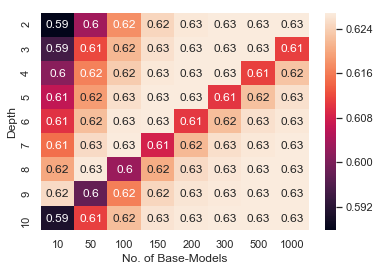

In [179]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

##### 3D Scatter Plot and Heatmap for CV AUC

In [180]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = [10,10,10,10,10,10,10,10,10,50,50,50,50,50,50,50,50,50,100,100,100,100,100,100,100,100,100,150,150,150,150,150,150,150,150,150,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000,1000,1000]
g2 = [2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,10]
g3 = list(gs.cv_results_['mean_test_score'])



ax.scatter(g1, g2, g3, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

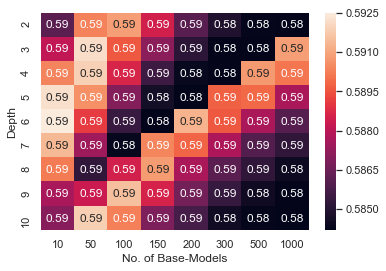

In [182]:
import seaborn as sns; sns.set()

data = pd.DataFrame(
    {
     'No. of Base-Models': g1,
     'Depth': g2,
     'AUC Score': g3,
    })
data = data.pivot('Depth','No. of Base-Models','AUC Score')
ax = sns.heatmap(data, annot=True)

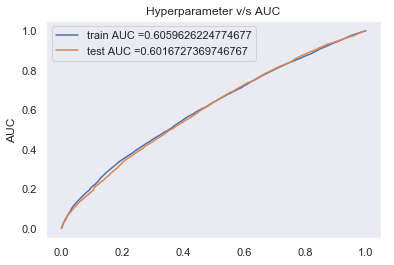

In [183]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

gbdt = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', max_depth = 2, n_estimators = 200)
gbdt.fit(x_tr_4,y_train[:40000])
    
y_train_pred_4 = pred_prob(gbdt,x_tr_4)
y_test_pred_4 = pred_prob(gbdt,x_te_4)
    
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train[:40000], y_train_pred_4)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test[:30000], y_test_pred_4)

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
# plt.xlabel("Lambda Inverse: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter v/s AUC")
plt.grid()
plt.show()

Train Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.60      0.29      6039
           1       0.89      0.55      0.68     33961

   micro avg       0.56      0.56      0.56     40000
   macro avg       0.54      0.57      0.48     40000
weighted avg       0.78      0.56      0.62     40000

Train Confusion Matrix:
[[ 3620  2419]
 [15274 18687]]


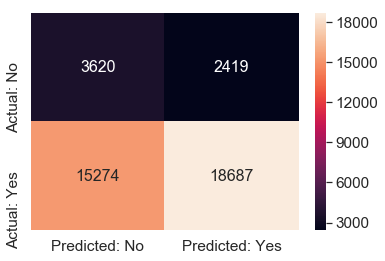

In [184]:
#https://medium.com/datadriveninvestor/simplifying-the-confusion-matrix-aa1fa0b0fc35

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_train_pred_labels = pred_prob_label(y_train_pred_4,tr_thresholds,train_tpr,train_fpr)
y_test_pred_labels = pred_prob_label(y_test_pred_4,te_thresholds,test_tpr,test_fpr)

class_report_train = classification_report(y_train[:40000], y_train_pred_labels)
class_report_test = classification_report(y_test[:30000], y_test_pred_labels)

df_cm = pd.DataFrame(confusion_matrix(y_train[:40000], y_train_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Train Classification Report:')
print(class_report_train)
print('Train Confusion Matrix:')
print(confusion_matrix(y_train[:40000], y_train_pred_labels))



Test Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.55      0.28      4484
           1       0.88      0.59      0.71     25516

   micro avg       0.58      0.58      0.58     30000
   macro avg       0.54      0.57      0.49     30000
weighted avg       0.78      0.58      0.64     30000

Test Confusion Matrix:


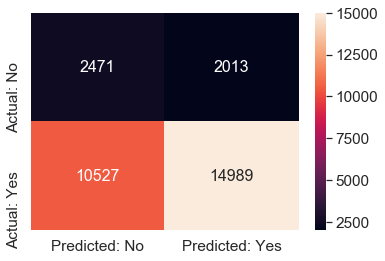

In [185]:
df_cm = pd.DataFrame(confusion_matrix(y_test[:30000], y_test_pred_labels), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

print('Test Classification Report:')
print(class_report_test)
print('Test Confusion Matrix:')

## 6. Conclusion

In [186]:
#https://http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

table1 = PrettyTable()

table1.field_names = ['Set','Model','depth','n_estimators','Train AUC Score','Test AUC Score']

table1.add_row(['Set 1','Random Forrest',10,1000,0.82,0.70])
table1.add_row(['Set 2','Random Forrest',10,1000,0.84,0.69])
table1.add_row(['Set 3','Random Forrest',6,500,0.71,0.60])
table1.add_row(['Set 4','Random Forrest',7,500,0.64,0.60])

In [187]:
print('Random Forest Results');
print(table1)

Random Forest Results
+-------+----------------+-------+--------------+-----------------+----------------+
|  Set  |     Model      | depth | n_estimators | Train AUC Score | Test AUC Score |
+-------+----------------+-------+--------------+-----------------+----------------+
| Set 1 | Random Forrest |   10  |     1000     |       0.82      |      0.7       |
| Set 2 | Random Forrest |   10  |     1000     |       0.84      |      0.69      |
| Set 3 | Random Forrest |   6   |     500      |       0.71      |      0.6       |
| Set 4 | Random Forrest |   7   |     500      |       0.64      |      0.6       |
+-------+----------------+-------+--------------+-----------------+----------------+


In [188]:
table2 = PrettyTable()
table2.field_names = ['Set','Model','depth','n_estimators','Train AUC Score','Test AUC Score']

table2.add_row(['Set 1','GBDT',2,1000,0.79,0.73])
table2.add_row(['Set 2','GBDT',2,1000,0.80,0.73])
table2.add_row(['Set 3','GBDT',2,50,0.65,0.63])
table2.add_row(['Set 4','GBDT',2,200,0.61,0.60])

In [189]:
print('GBDT Results');
print(table2)

GBDT Results
+-------+-------+-------+--------------+-----------------+----------------+
|  Set  | Model | depth | n_estimators | Train AUC Score | Test AUC Score |
+-------+-------+-------+--------------+-----------------+----------------+
| Set 1 |  GBDT |   2   |     1000     |       0.79      |      0.73      |
| Set 2 |  GBDT |   2   |     1000     |       0.8       |      0.73      |
| Set 3 |  GBDT |   2   |      50      |       0.65      |      0.63      |
| Set 4 |  GBDT |   2   |     200      |       0.61      |      0.6       |
+-------+-------+-------+--------------+-----------------+----------------+
